In [13]:
import os
import warnings
import logging
import math
import shap # type: ignore
import umap # type: ignore
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import ExperimentalWarning
import optuna_distributed # type: ignore
from tqdm import tqdm
from sklearn_pandas import DataFrameMapper # type: ignore
from sklearn.base import  clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss, roc_auc_score, auc, roc_curve, balanced_accuracy_score, f1_score, recall_score, precision_score 
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from typing import Union, Optional, Tuple, Dict, List, Set, Iterable, Callable
from contextlib import contextmanager

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns 

In [3]:
%matplotlib inline

sns.set_style('ticks')
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 150

# **Functions**

In [14]:
@contextmanager
def suppress_warnings(categories):
    with warnings.catch_warnings():
        for category in categories:
            warnings.filterwarnings("ignore", category=category)
        yield

In [15]:
def perform_pca_umap(
        df: pd.DataFrame,
        n_components_pca: int = 30, 
        n_components_umap: int = 2, 
        std_scaler: bool = True,
        plot_title: str = 'UMAP Projection of PCA-Reduced Data',
        hue: bool = 'batch',
        ax=None
) -> None:
    """
    Perform PCA followed by UMAP on the given DataFrame and plot the results.

    Args:
        X: DataFrame containing the data to be processed.
        y: Optional iterable of integers specifying the class labels for each row in X.
        n_components_pca: Number of components for PCA.
        n_components_umap: Number of components for UMAP.
        std_scaler: Whether to standardize the data before PCA.
        plot_title: Title for the plot.
        ax: Axis to plot on. If None, a new figure will be created.
    """
    batch_ids = df['batch_name']
    y = df['t1d_status']
    X = df.loc[:, [i for i in df.columns if 'dim' in i]]
    
    # Standartize data if needed
    if std_scaler:
        X = StandardScaler().fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=n_components_pca, svd_solver='arpack', random_state=42)
    pca_result = pca.fit_transform(X)

    # Perform UMAP
    umap_model = umap.UMAP(n_components=n_components_umap, random_state=42)
    umap_result = umap_model.fit_transform(pca_result)
    umap_result = pd.DataFrame(umap_result, columns=['umap_1', 'umap_2'])

    if hue == 'batch':
        umap_result['hue_ids'] = batch_ids
    elif hue == 'disease':
        umap_result['hue_ids'] = y

    # Plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6), dpi=100)
        
    sns.scatterplot(data=umap_result, x='umap_1', y='umap_2', alpha=0.5, hue='hue_ids', ax=ax)
    ax.set_title(plot_title)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid()

In [16]:
def update_metrics(y_true, y_pred, y_pred_proba, f1_scores, accuracy, tprs, aucs, recs, prs):
    mean_fpr = np.linspace(0, 1, 100) 
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    accuracy.append(balanced_accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred))
    recs.append(recall_score(y_true, y_pred))
    prs.append(precision_score(y_true, y_pred))

In [17]:
def optimize_kernel_logit_params(X, y, cv, n_trials=100):
    logging.getLogger("optuna").setLevel(logging.WARNING)
    logging.getLogger("optuna_distributed").setLevel(logging.WARNING)

    def objective(trial):
        """
        Optuna optimization objective with extended parameter space
        """
        params = {
            'rbf__gamma': trial.suggest_float('gamma', 1e-6, 1e3, log=True),
            'rbf__n_components': trial.suggest_int('n_components', 50, 500, step=50),
            'logreg__C': trial.suggest_float('C', 1e-6, 1e3, log=True),
            'logreg__solver': trial.suggest_categorical('solver', 
                                                    ['lbfgs', 'sag', 'saga']),
            'logreg__fit_intercept': trial.suggest_categorical('fit_intercept',
                                                            [True, False]),
            'logreg__max_iter': trial.suggest_int('max_iter', 1000, 2000, step=500),
            'logreg__class_weight': trial.suggest_categorical('class_weight',
                                                            [None, 'balanced'])
        }
        
        scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = Pipeline([
                ('rbf', RBFSampler(random_state=42)),
                ('logreg', LogisticRegression(penalty='l2', random_state=42))
            ]).set_params(**params)
            
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_val)[:, 1]
            scores.append(log_loss(y_val, y_proba))
            
        return np.mean(scores)
    
    sampler = TPESampler(seed=42, multivariate=True, group=True) 
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study = optuna_distributed.from_study(study)
    study.optimize(lambda trial: objective(trial), n_trials, n_jobs=-1)

    best_params = study.best_params
    best_params = {
        f"rbf__{k}" if k in ['gamma', 'n_components'] else f"logreg__{k}": v 
        for k, v in best_params.items()
    }
    return best_params

In [18]:
def optimize_random_forest_params(X, y, preprocesser, cv, n_trials=100):
    logging.getLogger("optuna").setLevel(logging.WARNING)
    logging.getLogger("optuna_distributed").setLevel(logging.WARNING)

    def objective(trial):
        """
        Define objective for `optuna.study`
        """
        params = {
            'max_depth': trial.suggest_int("max_depth", 3, 15),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 3, 10),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            'class_weight': trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample", None]),
            'n_estimators': 500,
            'n_jobs': 1,
            'random_state': 42
        }

        obj_model = RandomForestClassifier(**params)

        preprocesser_cv = clone(preprocesser)
        estimator = make_pipeline(preprocesser_cv, obj_model)

        obj_f1_score = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()
        return obj_f1_score

    sampler = TPESampler(seed=42, multivariate=True, group=True) 
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study = optuna_distributed.from_study(study)
    study.optimize(lambda trial: objective(trial), n_trials, n_jobs=-1)

    best_params = study.best_params
    return best_params

In [19]:
def optimize_random_forest_params2(X, y, dim_reduct_method, cv, n_trials=50):
    logging.getLogger("optuna").setLevel(logging.WARNING)
    logging.getLogger("optuna_distributed").setLevel(logging.WARNING)

    def objective(trial):
        """
        Define objective for `optuna.study
        """
        # Define dimentionality reduction algorith's hyperparameters
        if dim_reduct_method in ['pca', 'PCA']:
            dim_reduct_params = {
                "n_components": trial.suggest_int("n_components", 20, 100, 10),
                "svd_solver": 'arpack',
                "random_state": 42 
                }
        elif dim_reduct_method in ['umap', 'UMAP']:
            dim_reduct_params = {
                'n_components': trial.suggest_int('umap_n_components', 10, 110, 20),
                'n_neighbors': trial.suggest_int('umap_n_neighbors', 5, 50, 5),
                'min_dist': trial.suggest_float('umap_min_dist', 0.01, 0.99),
                'metric': trial.suggest_categorical('umap_metric', ['euclidean', 'cosine'])
            }

        # Suggest weights for class 0 (negatives) and class 1 (positives)
        weight_neg = trial.suggest_float('weight_neg', 1.0, 10.0)  # Higher weight for minority
        weight_pos = trial.suggest_float('weight_pos', 0.1, 1.0)   # Lower weight for majority
        
        # Create class_weight dictionary
        class_weights = {0: weight_neg, 1: weight_pos}

        rf_params = {
            'max_depth': trial.suggest_int("max_depth", 3, 15),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 3, 10),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            'class_weight': class_weights,
            'n_estimators': 200,
            'n_jobs': 1,
            'random_state': 42
        }

        # Create the preprocessing pipeline for columns that need processing
        processing_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('dim_reduct', PCA(**dim_reduct_params) if dim_reduct_method in ['pca', 'PCA'] else umap.UMAP(**dim_reduct_params))
        ])

        # ColumnTransformer handles both processed and skipped features
        preprocesser = ColumnTransformer([
            ('process', processing_pipeline, [i for i in X.columns if 'dim' in i]),
            ('passthrough', 'passthrough', ['entropy'])
        ])

        estimator = make_pipeline(preprocesser, RandomForestClassifier(**rf_params))

        # Track scores across folds
        score = cross_val_score(
            estimator,
            X, y,
            cv=cv,
            scoring='f1',
            n_jobs=1
        ).mean()

        # Return the mean F1 score
        return score

    sampler = TPESampler(seed=42, multivariate=True, group=True) 
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study = optuna_distributed.from_study(study)
    study.optimize(lambda trial: objective(trial), n_trials, n_jobs=-1)

    best_params = study.best_params
    return best_params

In [20]:
def optimize_xgboost_params2(X, y, dim_reduct_method, cv, n_trials=100):
    logging.getLogger("optuna").setLevel(logging.WARNING)

    def objective(trial):
        """
        Define objective for `optuna.study` with only the most impactful parameters
        """
        # Define dimentionality reduction algorith's hyperparameters
        if dim_reduct_method in ['pca', 'PCA']:
            dim_reduct_params = {
                "n_components": trial.suggest_int("n_components", 10, 100, 5),
                "svd_solver": 'arpack',
                "random_state": 42 
                }
        elif dim_reduct_method in ['umap', 'UMAP']:
            dim_reduct_params = {
                'n_components': trial.suggest_int('umap_n_components', 5, 40, 5),
                'n_neighbors': trial.suggest_int('umap_n_neighbors', 5, 50, 5),
                'min_dist': trial.suggest_float('umap_min_dist', 0.01, 0.99),
                'metric': trial.suggest_categorical('umap_metric', ['euclidean', 'cosine'])
            }
                                                            

        # Define core XGBoost hyperparameters to tune
        xgb_params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "tree_method": 'hist',
            "device": "cuda",
            "random_state": 42,
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.2, 0.7, log=False),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        }

        # Create the preprocessing pipeline for columns that need processing
        processing_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('dim_reduct', PCA(**dim_reduct_params) if dim_reduct_method in ['pca', 'PCA'] else umap.UMAP(**dim_reduct_params))
        ])

        # ColumnTransformer handles both processed and skipped features
        preprocesser = ColumnTransformer([
            ('process', processing_pipeline, [i for i in X.columns if 'dim' in i]),
            ('passthrough', 'passthrough', ['entropy'])
        ])
              
        # Track scores across folds
        obj_f1_scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Preprocess data
            preprocesser_cv = clone(preprocesser)
            X_train_prep = preprocesser_cv.fit_transform(X_train)
            X_val_prep = preprocesser_cv.transform(X_val)

            # Convert preprocessed data to DMatrix
            dtrain_fold = xgb.DMatrix(X_train_prep, label=y_train)
            dval_fold = xgb.DMatrix(X_val_prep, label=y_val)

            # Train the model with early stopping
            model = xgb.train(
                xgb_params,
                dtrain_fold,
                num_boost_round=1000,  # Increase the number of boosting rounds
                evals=[(dval_fold, "validation")],
                early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
                verbose_eval=False,  # Disable verbose output
            )
            
            # Make predictions on the validation set
            y_pred = model.predict(dval_fold)
            y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

            # Predict and evaluate
            fold_score = f1_score(y_val, y_pred)
            obj_f1_scores.append(fold_score)
        
        # Return the mean F1 score
        return np.mean(obj_f1_scores)

    sampler = TPESampler(seed=42, multivariate=True, group=True) 
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial), n_trials, n_jobs=1)

    best_params = study.best_params
    return best_params

In [21]:
def optimize_xgboost_params(X, y, preprocesser, cv, n_trials=100):
    logging.getLogger("optuna").setLevel(logging.WARNING)
    logging.getLogger("optuna_distributed").setLevel(logging.WARNING)

    def objective(trial):
        """
        Define objective for `optuna.study` with only the most impactful parameters
        """

        # Define core XGBoost hyperparameters to tune
        params = {
            "objective": "binary:logistic",  # Binary classification
            "eval_metric": "auc",  # Evaluation metric for binary classification,
            "tree_method": 'hist',  # or 'gpu_exact'
            "device": "cuda",
            "scale_pos_weight": (len(y) - sum(y)) / sum(y),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),  # L2 regularization
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),  # Minimum loss reduction
            "random_state": 42
        }
              
        # Track scores across folds
        obj_f1_scores = []
        
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Preprocess data
            preprocesser_cv = clone(preprocesser)
            X_train_prep = preprocesser_cv.fit_transform(X_train)
            X_val_prep = preprocesser_cv.transform(X_val)

            # Convert preprocessed data to DMatrix
            dtrain_fold = xgb.DMatrix(X_train_prep, label=y_train)
            dval_fold = xgb.DMatrix(X_val_prep, label=y_val)
            
            # # Train with early stopping
            # model = xgb.XGBClassifier(**params)
            # model.fit(
            #     X_train_prep, y_train,
            #     eval_set=[(X_val_prep, y_val)],
            #     verbose=False
            # )

            # Train the model with early stopping
            model = xgb.train(
                params,
                dtrain_fold,
                num_boost_round=1000,  # Increase the number of boosting rounds
                evals=[(dval_fold, "validation")],
                early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
                verbose_eval=False,  # Disable verbose output
            )
            
            # Make predictions on the validation set
            y_pred = model.predict(dval_fold)
            y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

            # Predict and evaluate
            # y_pred = model.predict(X_val_prep)
            fold_score = f1_score(y_val, y_pred)
            obj_f1_scores.append(fold_score)
        
        # Return the mean F1 score
        return np.mean(obj_f1_scores)

    sampler = TPESampler(seed=42, multivariate=True, group=True) 
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial), n_trials, n_jobs=1)

    best_params = study.best_params
    return best_params

In [22]:
def intitialize_shap_dict(X, cv_repeats):
    '''initialize a dict to track the SHAP values of each observation per CV repitition'''

    shap_values_per_cv = dict()
    for sample in X.index:
        ## Create keys for each sample
        shap_values_per_cv[sample] = {} 
        ## Then, keys for each CV fold within each sample
        for cv_repeat in range(cv_repeats):
            shap_values_per_cv[sample][cv_repeat] = {}
    return shap_values_per_cv

In [23]:
def preprocesser(X: pd.DataFrame, include_batch: bool = False, n_components=30):
    entropy_prep = ('entropy', None)
    dim_prep = ([i for i in X.columns if 'dim' in i], [StandardScaler(), PCA(n_components=n_components, svd_solver='arpack', random_state=42)], {'alias': 'PC'})
    prep = [ dim_prep, entropy_prep ]
    if include_batch:
        batch_prep = (['batch_name'], OneHotEncoder(), {'alias': 'batch'})
        prep.append(batch_prep)
        
    return DataFrameMapper(prep, input_df=True, df_out=True)

In [24]:
def nested_cv_model(X, y, preprocesser, model_name, cv_repeats=2, print_res=True, random_seed=52):

    np.random.seed(random_seed) 
    random_states = np.random.randint(10000, size=cv_repeats)
    
    shap_values_per_cv = intitialize_shap_dict(X, cv_repeats)

    metric_dict = {'f1_scores': [], 'accuracy': [],'tprs': [], 'aucs': [], 'recs': [], 'prs': []}

    for cv_repeat in range(cv_repeats):
        print('\n------------ CV Repeat number:', cv_repeat+1)
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_states[cv_repeat])
        
        with suppress_warnings([ExperimentalWarning, FutureWarning]):
            for fold, (outer_train_index, outer_test_index) in enumerate(outer_cv.split(X, y)):
                print('\n------ Fold Number:',fold+1)
                
                X_outer_train, X_outer_test = X.iloc[outer_train_index, :], X.iloc[outer_test_index, :]
                y_outer_train, y_outer_test = y[outer_train_index], y[outer_test_index] 
                
                if model_name in ['rf', 'random_forest', 'randomforest']:
                    best_params = optimize_random_forest_params(X_outer_train, y_outer_train, preprocesser)
                    best_model = RandomForestClassifier(**best_params)
                    preprocesser_cv = clone(preprocesser)
                    best_estimator = make_pipeline(preprocesser_cv, best_model)
                elif model_name in ['xgb', 'xgboost']:
                    best_params = optimize_xgboost_params(X_outer_train, y_outer_train, preprocesser)
                    best_model = xgb.XGBClassifier(**best_params)
                    preprocesser_cv = clone(preprocesser)
                    best_estimator = make_pipeline(preprocesser_cv, best_model)
                elif model_name in ['kernel_logit', 'kernel_logreg']:
                    best_params = optimize_kernel_logit_params(X_outer_train, y_outer_train)
                    best_estimator = Pipeline([
                        ('rbf', RBFSampler(random_state=random_seed)),
                        ('logreg', LogisticRegression(penalty='l2', random_state=random_seed))
                    ]).set_params(**best_params)
                
                best_estimator.fit(X_outer_train, y_outer_train)
                y_outer_test_pred = best_estimator.predict(X_outer_test)
                y_outer_test_proba = best_estimator.predict_proba(X_outer_test)[:, 1]

                update_metrics(y_outer_test, y_outer_test_pred, y_outer_test_proba, **metric_dict)
                print(f'F1 Score: {f1_score(y_outer_test, y_outer_test_pred):.3f}')
                print(f'Balanced Accuracy: {balanced_accuracy_score(y_outer_test, y_outer_test_pred):.3f}')
                print(f'AUC ROC: {roc_auc_score(y_outer_test, y_outer_test_proba):.3f}')

                # # Use SHAP to explain predictions using best model   
                # if model_name in ['kernel_logit', 'kernel_logreg']:
                #     background = shap.kmeans(X_outer_train, 100)
                #     explainer = shap.KernelExplainer(best_estimator.predict_proba, background)
                #     shap_values = explainer.shap_values(np.array(X_outer_test), check_additivity=True)
                # else:
                #     preprocesser_cv = clone(preprocesser)
                #     Xt_outer_test = preprocesser_cv.fit_transform(X_outer_test)
                #     best_model.fit(Xt_outer_test, y_outer_test)
                #     explainer = shap.TreeExplainer(best_model) 
                #     shap_values = explainer.shap_values(np.array(Xt_outer_test), check_additivity=True)

                # # Extract SHAP information per fold per sample
                # for i, test_index in enumerate(outer_test_index):
                #     if model_name in ['rf', 'random_forest', 'randomforest']:
                #         shap_values_per_cv[test_index][cv_repeat] = shap_values[:, :, 1][i]
                #     elif model_name in ['xgb', 'xgboost']:
                #         shap_values_per_cv[test_index][cv_repeat] = shap_values[i]
                #     elif model_name in ['kernel_logit', 'kernel_logreg']:
                #         shap_values_per_cv[test_index][cv_repeat] = shap_values[i]
    
    average_shap_values, stds, ranges = [],[],[]

    # for i in range(0, len(X)):
    #     df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
    #     # Get relevant statistics for every sample 
    #     average_shap_values.append(df_per_obs.mean(axis=1).values) 
    #     stds.append(df_per_obs.std(axis=1).values)
    #     ranges.append(df_per_obs.max(axis=1).values - df_per_obs.min(axis=1).values)
                
    # average_shap_values = np.array([list(i) for i in average_shap_values])

    metric_dict['f1_scores'] = np.array(metric_dict['f1_scores'])
    f1_score_mean = metric_dict['f1_scores'].mean()
    f1_score_int = 2.26 * metric_dict['f1_scores'].std() / math.sqrt(cv_repeats * 5)

    metric_dict['accuracy'] = np.array(metric_dict['accuracy'])
    accuracy_mean = metric_dict['accuracy'].mean()
    accuracy_sd = 2.26 * metric_dict['accuracy'].std() / math.sqrt(cv_repeats * 5)

    auc_scores = {
        'tprs': metric_dict['tprs'],
        'aucs': metric_dict['aucs']
    }

    if print_res:
        print()
        print(f"Mean Outer Nested CV Balanced Accuracy: {accuracy_mean:.3f} (±{accuracy_sd:.3f} 95% CI)")
        print(f"Mean Outer Nested CV F1 Score: {f1_score_mean:.3f} (±{f1_score_int:.3f} 95% CI)")
        print(f"Recall: { [ round(i, 3) for i in metric_dict['recs'] ] }, mean={np.mean(metric_dict['recs']):.3f}, sd={np.std(metric_dict['recs']):.3f}")
        print(f"Precision: {[round(i, 3) for i in metric_dict['prs']]}, mean={np.mean(metric_dict['prs']):.3f}, sd={np.std(metric_dict['prs']):.3f}")
    
    return average_shap_values, auc_scores

In [25]:
def plot_nestedCV_ROC(tprs, aucs, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6), dpi=150)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2.5, color='navy',
            label='Baseline', alpha=0.9)
    mean_fpr = np.linspace(0, 1, 100)     
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = 2.26 * np.std(aucs) / math.sqrt(len(aucs))
    ax.plot(mean_fpr, mean_tpr, color='darkorange',
        label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f} 95% CI)',
        lw=2.5, alpha=1.)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr+std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr-std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='black', alpha=.2,
                label=r'± 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right",
            frameon=False)
    
    if title:
        ax.set_title(title, fontsize=14)

    return ax

In [26]:
def plot_CV_ROC(y_true, y_pred_proba, model_name, title=None, color=None, plot_baseline=True, lw=2.5, ax=None):
    """
    Plots the ROC curve for a binary classification model.

    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1).
    y_pred_proba : array-like
        Predicted probabilities for the positive class (1).
    model_name : str, optional
        Name of the model (for legend). Default: "Model".
    figsize : tuple, optional
        Figure size (width, height). Default: (8, 6).
    """
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    if ax is None:
        _, ax = plt.subplots(figsize=(6,6), dpi=150)

    ax.plot(fpr, tpr, color=color, lw=lw, alpha=1., 
             label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    if plot_baseline:
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Baseline', alpha=.7)
    
    # Customize plot
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

In [27]:
def plot_CV_PR(y_true, y_pred_proba, model_name, title=None, color=None, plot_baseline=True, lw=2.5, ax=None):
    """
    Plots the precision-recall curve and computes PRAUC.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    y_scores : array-like
        Target scores (probability estimates of the positive class)
    title : str, optional
        Title for the plot (default: 'Precision-Recall Curve')
    
    Returns:
    --------
    prauc : float
        Precision-Recall Area Under Curve (PRAUC)
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    
    # Compute PRAUC (average precision score)
    prauc = average_precision_score(y_true, y_pred_proba)
    
    # Create plot
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6), dpi=150)
    
    # Plot the precision-recall curve
    ax.step(recall, precision, where='post', color=color, alpha=1.,
            label=f'{model_name} (AUC = {prauc:.3f})', lw=lw)
    
    # Add baseline for random classifier
    if plot_baseline:
        positive_ratio = np.mean(y_true)
        ax.axhline(y=positive_ratio, color='navy', linestyle='--', 
                label=f'Random (AP = {positive_ratio:.3f})')
    
    # Set plot properties
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.45, 1.05])
    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True)
    
    plt.tight_layout()
    
    return ax

In [28]:
def intrinsic_dim_sample_wise(X, k=5):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    neighb = NearestNeighbors(n_neighbors=k + 1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample

In [29]:
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k

In [30]:
def repeated(func, X, nb_iter=100, random_state=None, verbose=0, mode='shuffle', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []

    iters = range(nb_iter)
    if verbose > 0:
        iters = tqdm(iters)
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

In [31]:
def organize_results(*repeated_args, **repeated_kw):
    res_dict = {
        'k_param': [i for i in range(repeated_kw['k1'], repeated_kw['k2']+1)],
        'mean_dim': [],
        '95_lower': [],
        '95_upper': []
    }
    n = repeated_kw['nb_iter']

    # Calculate percentiles for the 95% confidence interval
    lower_percentile = 0.05 / 2
    upper_percentile = 1 - lower_percentile

    # Calculate the indices corresponding to the lower and upper percentiles
    lower_index = int(np.floor(n * lower_percentile))
    upper_index = int(np.ceil(n * upper_percentile)) - 1

    # Execute the 'repeated' function to get the bootstrapped results.
    output = repeated(*repeated_args, **repeated_kw)

    # Determine the range of k values to iterate over, based on k1 and k2.
    k_interval = range(repeated_kw['k2'] - repeated_kw['k1'] + 1)

    # Iterate over the k values to calculate statistics for each k.
    for i in k_interval:
        # Extract the i-th result from each iteration and sort them.
        temp = sorted([value[i] for value in output])

        # Calculate the mean of the bootstrapped mean dimentionality statistics for the current k value.
        res_dict['mean_dim'].append(mean(temp))

        # Append the lower and upper bounds of the 95% confidence interval to the results dictionary.
        res_dict['95_lower'].append(temp[lower_index])
        res_dict['95_upper'].append(temp[upper_index])

    # Create a Pandas DataFrame from the results dictionary.
    return pd.DataFrame(res_dict)


def mean(lst):
    return sum(lst)/len(lst)

# **Data import**

In [32]:
df = pd.read_csv('data_30k_umi/esm_embeddings.csv', index_col=0)
df = df[~df.batch_name.isin(['T1D_batch3'])].reset_index(drop=True)
df

,patient_id,t1d_status,batch_name,num_sequences,entropy,dim_0,dim_1,dim_2,dim_3,dim_4,...,dim_1270,dim_1271,dim_1272,dim_1273,dim_1274,dim_1275,dim_1276,dim_1277,dim_1278,dim_1279
0,865S500009_b.tsv,Yes,T1D_batch1,27127,14.609026,0.036233,0.098301,0.141636,0.152166,-0.064763,...,-0.002080,-0.026092,-0.106119,0.122872,-0.025134,0.154568,-0.047417,0.006034,-0.112239,0.042376
1,865S500022_b.tsv,Yes,T1D_batch1,23892,13.794102,0.035139,0.096385,0.142667,0.152614,-0.068431,...,-0.005679,-0.026831,-0.105279,0.122728,-0.024076,0.153834,-0.044545,0.006148,-0.113160,0.042779
2,diabetis_103_TRB_S42.tsv,No,T1D_batch1,20733,13.406438,0.037836,0.100933,0.143808,0.155666,-0.069518,...,-0.006122,-0.023731,-0.105896,0.130392,-0.029207,0.154948,-0.049799,0.005015,-0.113509,0.037587
3,912500065_TRB_S33.tsv,Yes,T1D_batch1,21961,13.793933,0.035953,0.099684,0.139575,0.152081,-0.067737,...,-0.004115,-0.026153,-0.102233,0.125044,-0.025613,0.155296,-0.046445,0.002161,-0.112655,0.037730
4,912500066_TRB_S34.tsv,No,T1D_batch1,17780,12.318280,0.037526,0.100453,0.138308,0.153903,-0.065981,...,-0.003220,-0.026562,-0.101756,0.126509,-0.028473,0.152914,-0.045455,0.001794,-0.116843,0.039240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,A6-I202ob,No,aging,12250,9.740086,0.034340,0.098947,0.146055,0.159069,-0.065835,...,-0.002924,-0.032202,-0.107059,0.119460,-0.025920,0.159729,-0.051312,0.008883,-0.114887,0.046358
580,A6-I205ob,No,aging,11680,9.363468,0.036988,0.090838,0.156103,0.159921,-0.067828,...,-0.012292,-0.025219,-0.112079,0.121315,-0.028479,0.156562,-0.051477,0.011248,-0.114859,0.047395
581,A6-I207ob,No,aging,11087,8.895209,0.051646,0.108935,0.130499,0.160988,-0.057878,...,0.004412,-0.024942,-0.103353,0.113885,-0.028285,0.153764,-0.041488,0.005315,-0.122795,0.032663
582,A6-I210ob,No,aging,12526,9.800237,0.039230,0.102521,0.133121,0.166055,-0.067671,...,-0.007135,-0.028321,-0.098079,0.109565,-0.028477,0.156690,-0.049299,-0.000986,-0.121921,0.044092


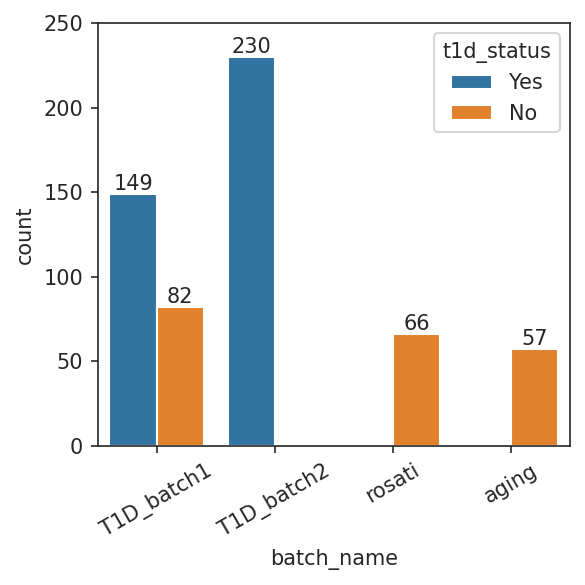

In [33]:
ax = sns.countplot(data=df, x='batch_name', hue='t1d_status')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=30)
plt.ylim(0, 250)
plt.tight_layout()

In [34]:
X = df.drop(columns=['patient_id', 't1d_status', 'num_sequences'])
y = df['t1d_status'].replace({'Yes': True, 'No': False}).map(int).values
X.head()

/scratch/ipykernel_1945939/909013133.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['t1d_status'].replace({'Yes': True, 'No': False}).map(int).values


,batch_name,entropy,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_1270,dim_1271,dim_1272,dim_1273,dim_1274,dim_1275,dim_1276,dim_1277,dim_1278,dim_1279
0,T1D_batch1,14.609026,0.036233,0.098301,0.141636,0.152166,-0.064763,-0.019096,-0.092516,0.207318,...,-0.002080,-0.026092,-0.106119,0.122872,-0.025134,0.154568,-0.047417,0.006034,-0.112239,0.042376
1,T1D_batch1,13.794102,0.035139,0.096385,0.142667,0.152614,-0.068431,-0.019970,-0.093037,0.210575,...,-0.005679,-0.026831,-0.105279,0.122728,-0.024076,0.153834,-0.044545,0.006148,-0.113160,0.042779
2,T1D_batch1,13.406438,0.037836,0.100933,0.143808,0.155666,-0.069518,-0.016430,-0.096374,0.212192,...,-0.006122,-0.023731,-0.105896,0.130392,-0.029207,0.154948,-0.049799,0.005015,-0.113509,0.037587
3,T1D_batch1,13.793933,0.035953,0.099684,0.139575,0.152081,-0.067737,-0.018350,-0.094349,0.211459,...,-0.004115,-0.026153,-0.102233,0.125044,-0.025613,0.155296,-0.046445,0.002161,-0.112655,0.037730
4,T1D_batch1,12.318280,0.037526,0.100453,0.138308,0.153903,-0.065981,-0.019733,-0.092610,0.208314,...,-0.003220,-0.026562,-0.101756,0.126509,-0.028473,0.152914,-0.045455,0.001794,-0.116843,0.039240


In [35]:
# Remove all batches execept for T1D_batch1
X_nob = df.loc[df.batch_name == 'T1D_batch1',:].reset_index(drop=True).drop(columns=['patient_id', 'batch_name', 't1d_status', 'num_sequences'])
y_nob = df.loc[df.batch_name == 'T1D_batch1', 't1d_status'].reset_index(drop=True).replace({'Yes': True, 'No': False}).map(int).values
X_nob

/scratch/ipykernel_1945939/2303794748.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_nob = df.loc[df.batch_name == 'T1D_batch1', 't1d_status'].reset_index(drop=True).replace({'Yes': True, 'No': False}).map(int).values


,entropy,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_1270,dim_1271,dim_1272,dim_1273,dim_1274,dim_1275,dim_1276,dim_1277,dim_1278,dim_1279
0,14.609026,0.036233,0.098301,0.141636,0.152166,-0.064763,-0.019096,-0.092516,0.207318,0.143783,...,-0.002080,-0.026092,-0.106119,0.122872,-0.025134,0.154568,-0.047417,0.006034,-0.112239,0.042376
1,13.794102,0.035139,0.096385,0.142667,0.152614,-0.068431,-0.019970,-0.093037,0.210575,0.140551,...,-0.005679,-0.026831,-0.105279,0.122728,-0.024076,0.153834,-0.044545,0.006148,-0.113160,0.042779
2,13.406438,0.037836,0.100933,0.143808,0.155666,-0.069518,-0.016430,-0.096374,0.212192,0.140408,...,-0.006122,-0.023731,-0.105896,0.130392,-0.029207,0.154948,-0.049799,0.005015,-0.113509,0.037587
3,13.793933,0.035953,0.099684,0.139575,0.152081,-0.067737,-0.018350,-0.094349,0.211459,0.139533,...,-0.004115,-0.026153,-0.102233,0.125044,-0.025613,0.155296,-0.046445,0.002161,-0.112655,0.037730
4,12.318280,0.037526,0.100453,0.138308,0.153903,-0.065981,-0.019733,-0.092610,0.208314,0.140468,...,-0.003220,-0.026562,-0.101756,0.126509,-0.028473,0.152914,-0.045455,0.001794,-0.116843,0.039240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,12.446692,0.038301,0.097933,0.139106,0.151580,-0.067251,-0.017608,-0.095333,0.212582,0.145543,...,-0.005670,-0.025496,-0.102959,0.127150,-0.026034,0.153604,-0.046869,0.006978,-0.113034,0.035149
227,12.996049,0.036308,0.099924,0.141527,0.154958,-0.065694,-0.017620,-0.093879,0.208655,0.140091,...,-0.001172,-0.027245,-0.104833,0.125865,-0.026567,0.154390,-0.048499,0.000599,-0.112569,0.037194
228,13.318313,0.034554,0.103756,0.137800,0.154922,-0.064197,-0.017160,-0.092418,0.205578,0.136755,...,-0.004190,-0.029808,-0.101930,0.124772,-0.022819,0.156503,-0.048996,0.002321,-0.108129,0.038098
229,13.924151,0.034002,0.101506,0.140413,0.152567,-0.064469,-0.017176,-0.095177,0.208965,0.139494,...,-0.001052,-0.027660,-0.103994,0.125455,-0.026024,0.157195,-0.050346,0.002250,-0.109423,0.037697


Explore data dimentionality in terms of principal components

Number of components covering 95% of variance: 28


Text(0, 0.5, 'Cumulative explained variance')

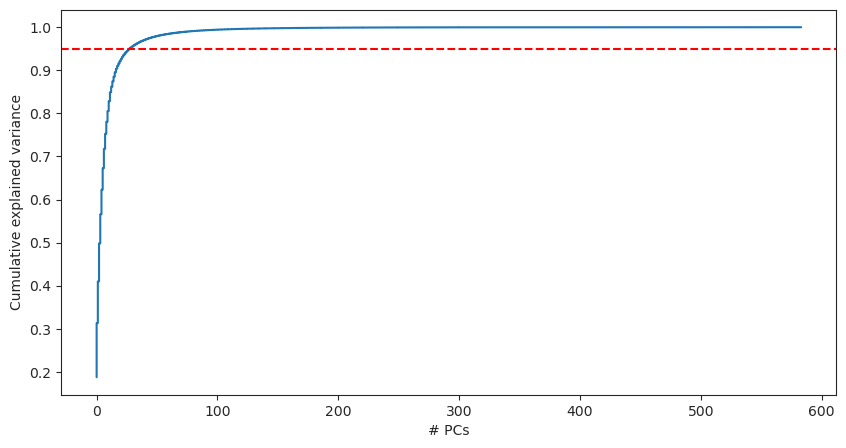

In [229]:
# Calculate 584 PCs
pca = make_pipeline(StandardScaler(), PCA(n_components=584))
pca.fit(X.iloc[:, 2:])

# Calculate cumulative explained variance
pca_step = pca.named_steps['pca']
cumulative_variance = np.cumsum(pca_step.explained_variance_ratio_)
print(f'Number of components covering 95% of variance: {len([float(i) for i in cumulative_variance if i <= 0.95])}')

# Plot results
_, ax = plt.subplots(figsize=(10, 5), dpi=100)

ax.step(x=list(range(584)), y=cumulative_variance, label='cumulative explained variance')
ax.axhline(y = 0.95, color = 'r', linestyle = '--', label='95$ explained variance')
ax.set_xlabel('# PCs')
ax.set_ylabel('Cumulative explained variance')
# ax.legend()

Number of components covering 95% of variance: 22


Text(0, 0.5, 'Cumulative explained variance')

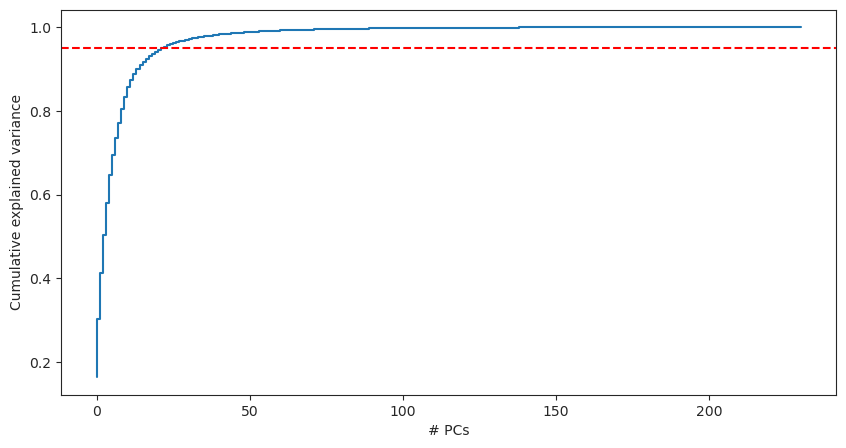

In [27]:
# Calculate 231 PCs
pca = make_pipeline(StandardScaler(), PCA(n_components=231))
pca.fit(X_nob.iloc[:, 1:])

# Calculate cumulative explained variance
pca_step = pca.named_steps['pca']
cumulative_variance = np.cumsum(pca_step.explained_variance_ratio_)
print(f'Number of components covering 95% of variance: {len([float(i) for i in cumulative_variance if i <= 0.95])}')

# Plot results
_, ax = plt.subplots(figsize=(10, 5), dpi=100)

ax.step(x=list(range(231)), y=cumulative_variance, label='cumulative explained variance')
ax.axhline(y = 0.95, color = 'r', linestyle = '--', label='95$ explained variance')
ax.set_xlabel('# PCs')
ax.set_ylabel('Cumulative explained variance')
# ax.legend()

Estimate intrinsic dimentionality via MLE method for T1D_batch1 data

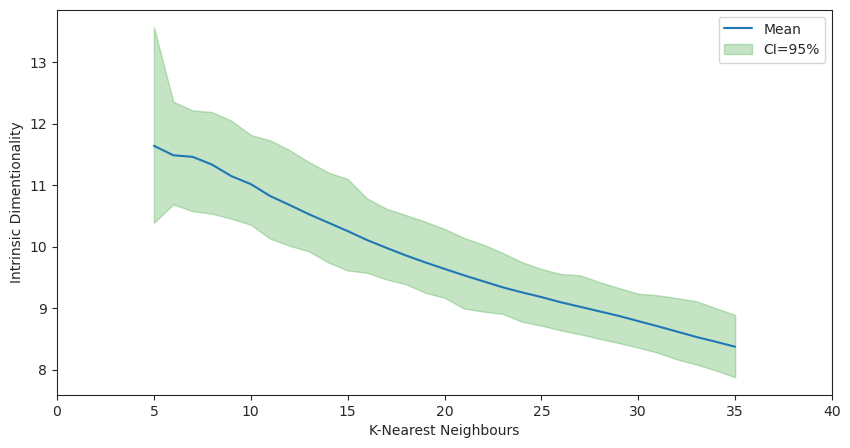

In [ ]:
# Calculate mean instrinsic dimentionalities depending on k values
dim_res = organize_results(intrinsic_dim_scale_interval, X_nob.iloc[:, 1:].to_numpy(), nb_iter=100, random_state=52, verbose=0, mode='bootstrap', k1=5, k2=35)

# Plot the results
_, ax = plt.subplots(figsize=(10, 5), dpi=100)

ax.plot('k_param', 'mean_dim', data=dim_res, c='tab:blue', label='Mean')
ax.fill_between(dim_res['k_param'], dim_res['95_lower'], dim_res['95_upper'], alpha=0.28, color='tab:green', label='CI=95%')
ax.set_xlim(3, 37)
ax.set_xlabel('K-Nearest Neighbours')
ax.set_ylabel('Intrinsic Dimentionality')
ax.legend()

In [42]:
print(f"MLE intinsic dimentionality: {dim_res.mean_dim.mean():.1f}")

MLE intinsic dimentionality: 9.8


Plot data in 2D UMAP

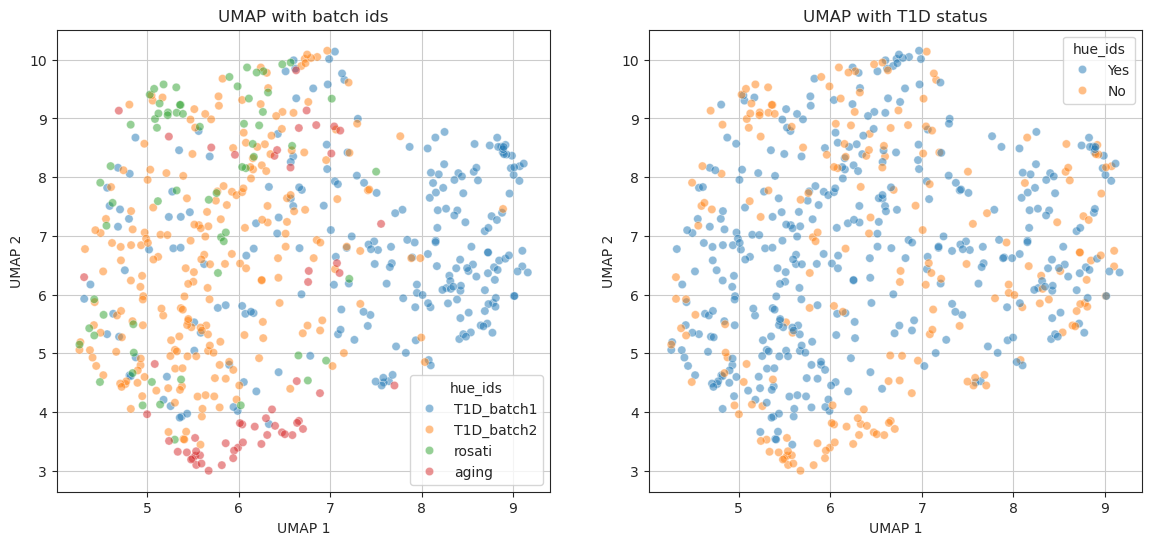

In [230]:
_, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
with suppress_warnings([FutureWarning, UserWarning]):
    perform_pca_umap(df, ax=axs[0], plot_title='UMAP with batch ids', hue='batch')
    perform_pca_umap(df, ax=axs[1], plot_title='UMAP with T1D status', hue='disease')

# **Nested-CV for T1D_batch1 data**

## Logistic Regression

Ridge Logit with Kernel

In [41]:
rbf_lr_average_shap, rbf_lr_auc_scores = nested_cv_model(X_nob, y_nob, preprocesser, model_name='kernel_logit', cv_repeats=3)


------------ CV Repeat number: 1

------ Fold Number: 1


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.779
Balanced Accuracy: 0.500
AUC ROC: 0.510

------ Fold Number: 2
F1 Score: 0.795
Balanced Accuracy: 0.546
AUC ROC: 0.494

------ Fold Number: 3
F1 Score: 0.789
Balanced Accuracy: 0.500
AUC ROC: 0.465

------ Fold Number: 4
F1 Score: 0.784
Balanced Accuracy: 0.515
AUC ROC: 0.635

------ Fold Number: 5


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.773
Balanced Accuracy: 0.500
AUC ROC: 0.606

------------ CV Repeat number: 2

------ Fold Number: 1


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.779
Balanced Accuracy: 0.500
AUC ROC: 0.535

------ Fold Number: 2


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.789
Balanced Accuracy: 0.500
AUC ROC: 0.544

------ Fold Number: 3
F1 Score: 0.773
Balanced Accuracy: 0.483
AUC ROC: 0.421

------ Fold Number: 4
F1 Score: 0.789
Balanced Accuracy: 0.500
AUC ROC: 0.631

------ Fold Number: 5
F1 Score: 0.732
Balanced Accuracy: 0.478
AUC ROC: 0.533

------------ CV Repeat number: 3

------ Fold Number: 1


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.773
Balanced Accuracy: 0.513
AUC ROC: 0.673

------ Fold Number: 2


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.773
Balanced Accuracy: 0.483
AUC ROC: 0.438

------ Fold Number: 3


/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.789
Balanced Accuracy: 0.500
AUC ROC: 0.602

------ Fold Number: 4
F1 Score: 0.773
Balanced Accuracy: 0.483
AUC ROC: 0.479

------ Fold Number: 5
F1 Score: 0.757
Balanced Accuracy: 0.483
AUC ROC: 0.349

Mean Outer Nested CV Balanced Accuracy: 0.499 (±0.010 95% CI)
Mean Outer Nested CV F1 Score: 0.777 (±0.009 95% CI)
Recall: [1.0, 0.967, 1.0, 0.967, 1.0, 1.0, 1.0, 0.967, 1.0, 0.897, 0.967, 0.967, 1.0, 0.967, 0.966], mean=0.977, sd=0.027
Precision: [0.638, 0.674, 0.652, 0.659, 0.63, 0.638, 0.652, 0.644, 0.652, 0.619, 0.644, 0.644, 0.652, 0.644, 0.622], mean=0.645, sd=0.014


<Axes: title={'center': 'Ridge Logistic Regression, RBFSampler\nT1D_batch1'}>

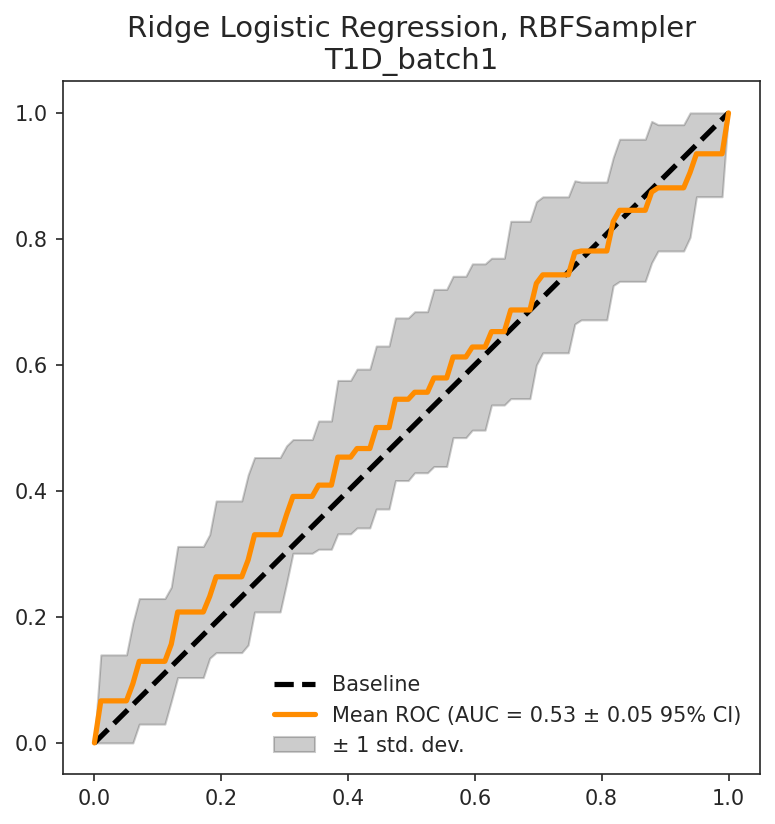

In [42]:
plot_nestedCV_ROC(rbf_lr_auc_scores['tprs'], rbf_lr_auc_scores['aucs'], title='Ridge Logistic Regression, RBFSampler\nT1D_batch1')

## Random Forest

Perform nested cross-validation to assess the random forest performance in predicting T1D status.

Explore batch effect influence on T1D status prediction

In [32]:
rf_only_batch_average_shap, rf_only_batch_auc_scores = nested_cv_model(X, y, preprocesser, model_name='random_forest', cv_repeats=2)


------------ CV Repeat number: 1

------ Fold Number: 1


F1 Score: 0.899
Balanced Accuracy: 0.793
AUC ROC: 0.924
4

------ Fold Number: 2
F1 Score: 0.905
Balanced Accuracy: 0.805
AUC ROC: 0.926
4

------ Fold Number: 3
F1 Score: 0.894
Balanced Accuracy: 0.780
AUC ROC: 0.925
4

------ Fold Number: 4
F1 Score: 0.910
Balanced Accuracy: 0.817
AUC ROC: 0.921
4

------ Fold Number: 5
F1 Score: 0.904
Balanced Accuracy: 0.805
AUC ROC: 0.914
4

------------ CV Repeat number: 2

------ Fold Number: 1
F1 Score: 0.884
Balanced Accuracy: 0.756
AUC ROC: 0.923
4

------ Fold Number: 2
F1 Score: 0.899
Balanced Accuracy: 0.793
AUC ROC: 0.905
4

------ Fold Number: 3
F1 Score: 0.905
Balanced Accuracy: 0.805
AUC ROC: 0.910
4

------ Fold Number: 4
F1 Score: 0.910
Balanced Accuracy: 0.817
AUC ROC: 0.930
4

------ Fold Number: 5
F1 Score: 0.915
Balanced Accuracy: 0.829
AUC ROC: 0.941
4

Mean Outer Nested CV Balanced Accuracy: 0.800 (±0.014 95% CI)
Mean Outer Nested CV F1 Score: 0.902 (±0.006 95% CI)
Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], mea

<Axes: title={'center': 'Random Forest, 30 PCs'}>

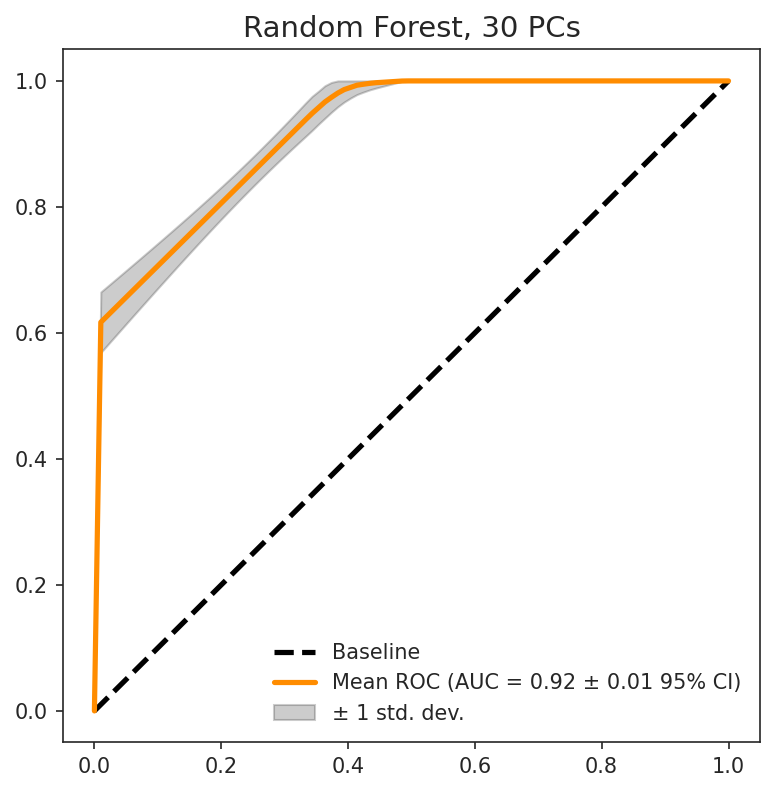

In [33]:
plot_nestedCV_ROC(rf_only_batch_auc_scores['tprs'], rf_only_batch_auc_scores['aucs'], title='Random Forest, 30 PCs')

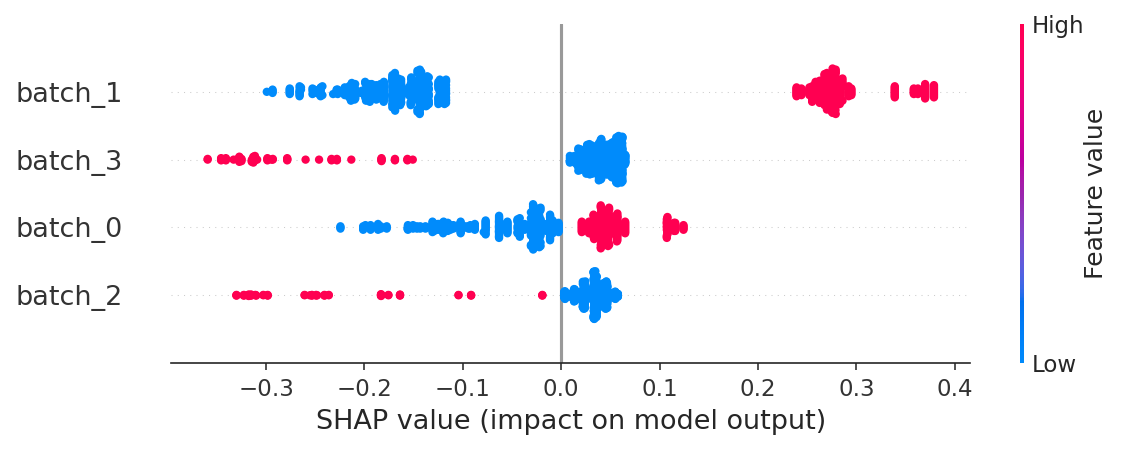

In [ ]:
X_t = preprocesser(X).fit_transform(X)
shap.summary_plot(np.array(rf_only_batch_average_shap), X_t, show = False)

Perform nested-CV model validation on T1D batch1 only

In [ ]:
data_prep = preprocesser(X_nob, include_batch=False)
rf_average_shap, rf_auc_scores = nested_cv_model(X_nob, y_nob, data_prep, model_name='random_forest', cv_repeats=3)


------------ CV Repeat number: 1

------ Fold Number: 1
F1 Score: 0.789
Balanced Accuracy: 0.529
AUC ROC: 0.492
31

------ Fold Number: 2
F1 Score: 0.789
Balanced Accuracy: 0.500
AUC ROC: 0.594
31

------ Fold Number: 3
F1 Score: 0.767
Balanced Accuracy: 0.498
AUC ROC: 0.456
31

------ Fold Number: 4
F1 Score: 0.824
Balanced Accuracy: 0.654
AUC ROC: 0.685
31

------ Fold Number: 5
F1 Score: 0.778
Balanced Accuracy: 0.542
AUC ROC: 0.635
31

------------ CV Repeat number: 2

------ Fold Number: 1
F1 Score: 0.779
Balanced Accuracy: 0.500
AUC ROC: 0.612
31

------ Fold Number: 2
F1 Score: 0.784
Balanced Accuracy: 0.515
AUC ROC: 0.575
31

------ Fold Number: 3
F1 Score: 0.761
Balanced Accuracy: 0.512
AUC ROC: 0.577
31

------ Fold Number: 4
F1 Score: 0.773
Balanced Accuracy: 0.483
AUC ROC: 0.554
31

------ Fold Number: 5
F1 Score: 0.750
Balanced Accuracy: 0.495
AUC ROC: 0.748
31

------------ CV Repeat number: 3

------ Fold Number: 1
F1 Score: 0.773
Balanced Accuracy: 0.513
AUC ROC: 0.575

<Axes: title={'center': 'Random Forest, 30 PCs\nT1D_batch1'}>

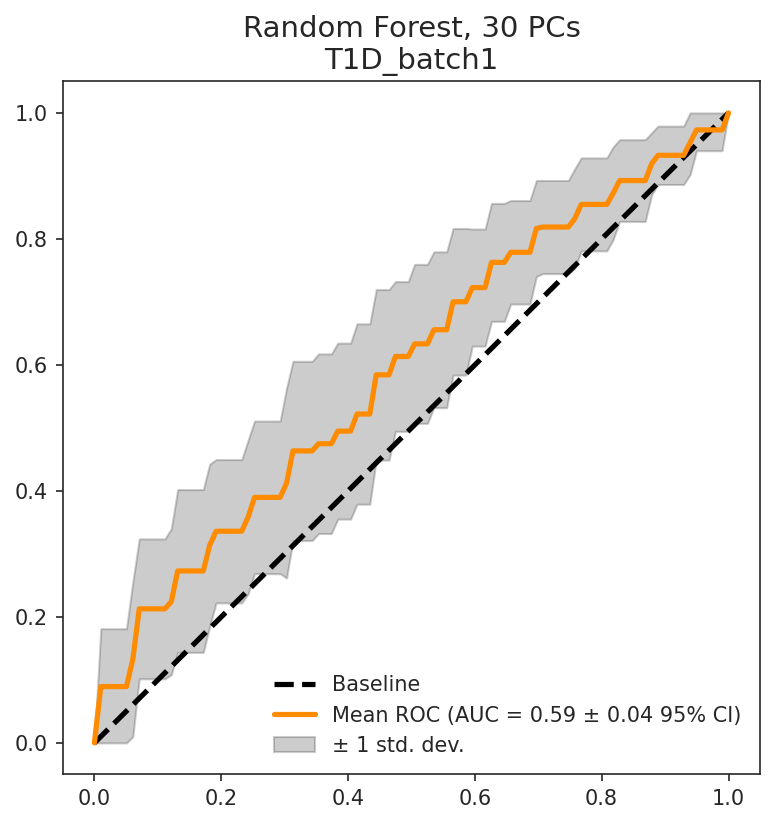

In [50]:
plot_nestedCV_ROC(rf_auc_scores['tprs'], rf_auc_scores['aucs'], title='Random Forest, 30 PCs\nT1D_batch1')

/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


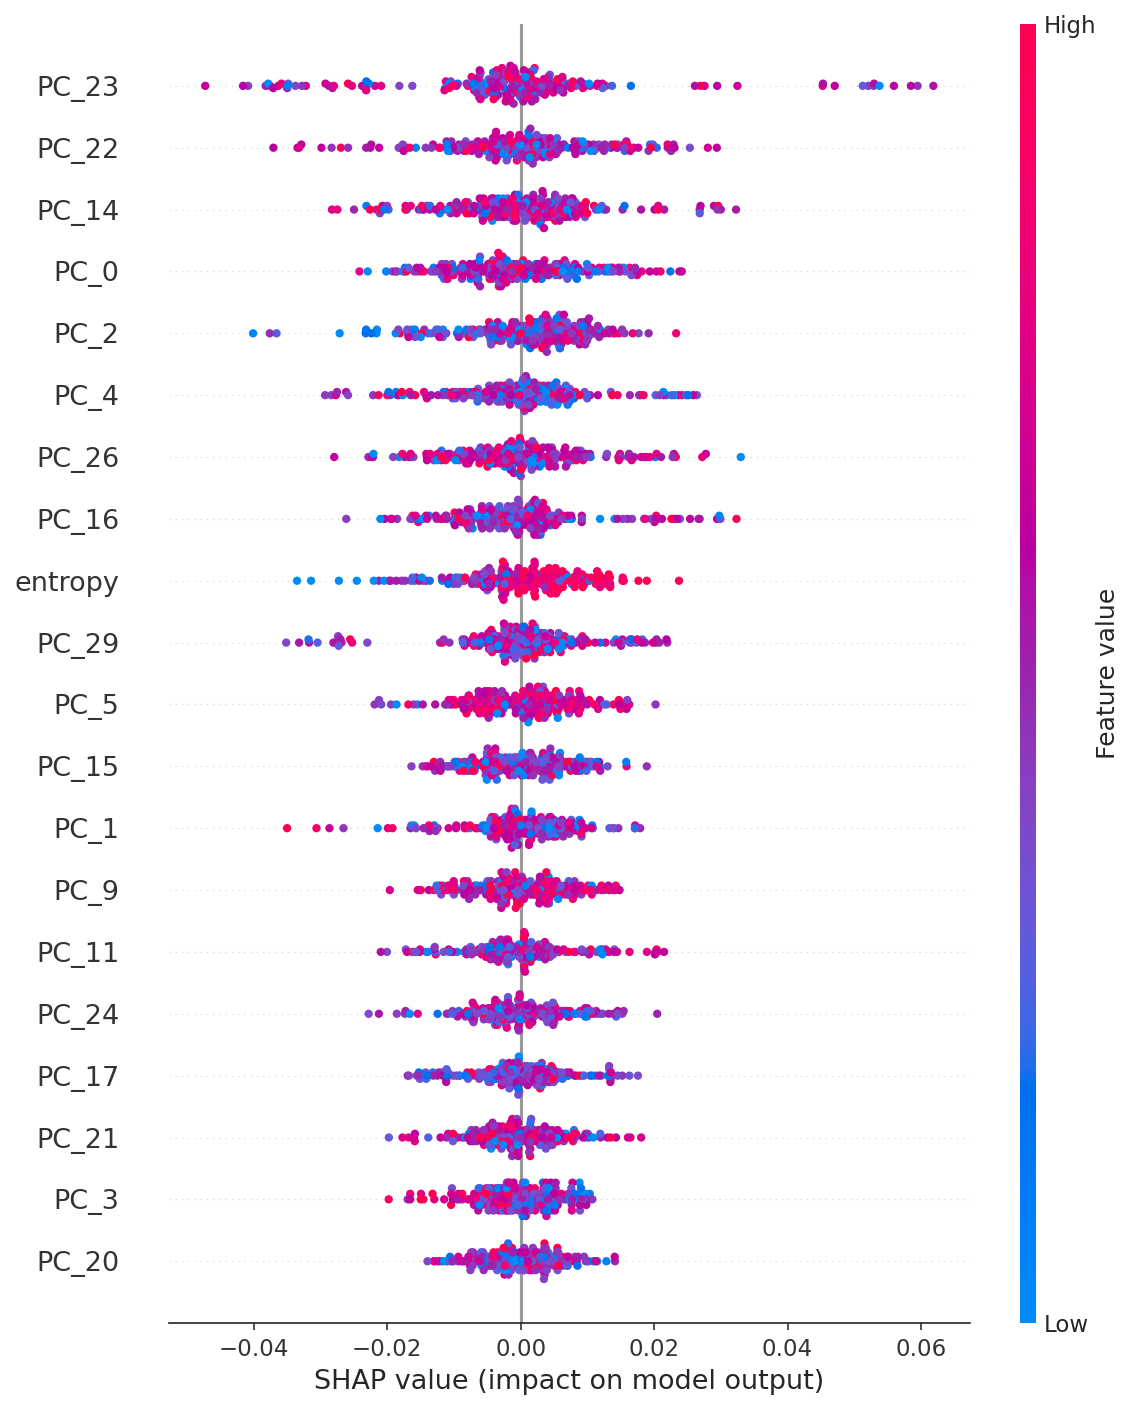

In [46]:
Xnob_t = data_prep.fit_transform(X_nob)
shap.summary_plot(np.array(rf_average_shap), Xnob_t, show = False)

In [ ]:
prep = [ ([i for i in X.columns if 'dim' in i], [StandardScaler(), umap.UMAP(n_components=25)], {'alias': 'PC'}),
         ('entropy', None) ]
data_prep = DataFrameMapper(prep, input_df=True, df_out=True)
rf_umap_average_shap, rf_umap_auc_scores = nested_cv_model(X_nob, y_nob, data_prep, model_name='random_forest', cv_repeats=3)


------------ CV Repeat number: 1

------ Fold Number: 1


F1 Score: 0.747
Balanced Accuracy: 0.467
AUC ROC: 0.470
26

------ Fold Number: 2
F1 Score: 0.773
Balanced Accuracy: 0.483
AUC ROC: 0.480
26

------ Fold Number: 3
F1 Score: 0.784
Balanced Accuracy: 0.515
AUC ROC: 0.546
26

------ Fold Number: 4
F1 Score: 0.784
Balanced Accuracy: 0.515
AUC ROC: 0.522
26

------ Fold Number: 5
F1 Score: 0.789
Balanced Accuracy: 0.571
AUC ROC: 0.436
26

------------ CV Repeat number: 2

------ Fold Number: 1
F1 Score: 0.763
Balanced Accuracy: 0.483
AUC ROC: 0.542
26

------ Fold Number: 2
F1 Score: 0.767
Balanced Accuracy: 0.498
AUC ROC: 0.392
26

------ Fold Number: 3
F1 Score: 0.767
Balanced Accuracy: 0.498
AUC ROC: 0.592
26

------ Fold Number: 4
F1 Score: 0.789
Balanced Accuracy: 0.500
AUC ROC: 0.547
26

------ Fold Number: 5
F1 Score: 0.757
Balanced Accuracy: 0.483
AUC ROC: 0.529
26

------------ CV Repeat number: 3

------ Fold Number: 1
F1 Score: 0.763
Balanced Accuracy: 0.483
AUC ROC: 0.467
26

------ Fold Number: 2
F1 Score: 0.833
Balanced Accur

<Axes: title={'center': 'Random Forest, 25 UMAPs\nT1D_batch1'}>

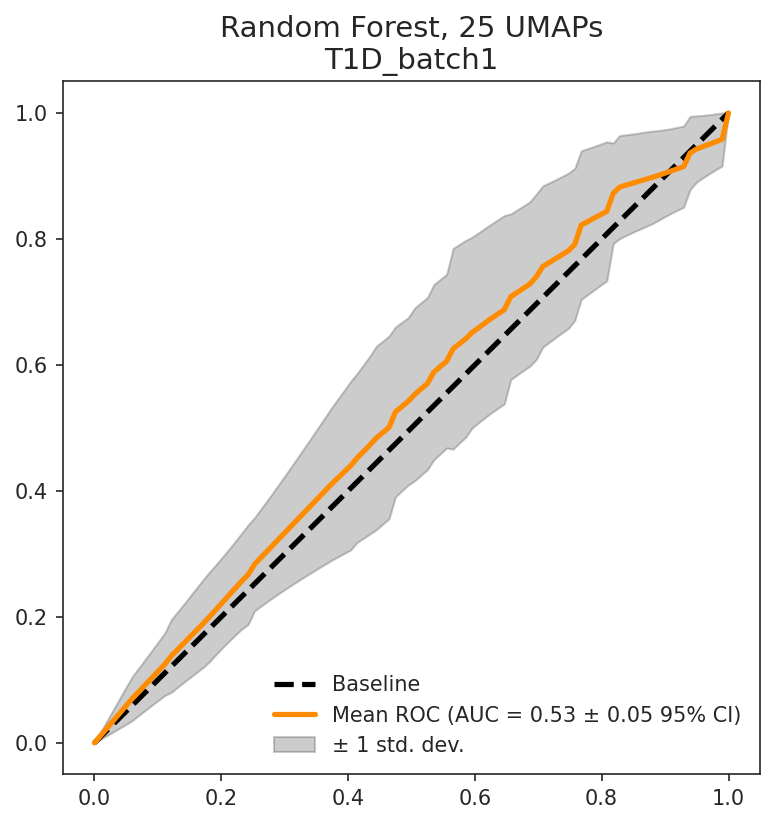

In [51]:
plot_nestedCV_ROC(rf_umap_auc_scores['tprs'], rf_umap_auc_scores['aucs'], title='Random Forest, 25 UMAPs\nT1D_batch1')

## XGBoost

Perform nested cross-validation to assess xgboost prediction of T1D status in T1D batch1 only.

In [66]:
xgb_average_shap, xgb_auc_scores = nested_cv_model(X_nob, y_nob, data_prep, model_name='xgboost', cv_repeats=3)


------------ CV Repeat number: 1

------ Fold Number: 1
F1 Score: 0.789
Balanced Accuracy: 0.529
AUC ROC: 0.522
31

------ Fold Number: 2
F1 Score: 0.767
Balanced Accuracy: 0.498
AUC ROC: 0.488
31

------ Fold Number: 3
F1 Score: 0.778
Balanced Accuracy: 0.529
AUC ROC: 0.450
31

------ Fold Number: 4
F1 Score: 0.795
Balanced Accuracy: 0.546
AUC ROC: 0.710
31

------ Fold Number: 5
F1 Score: 0.771
Balanced Accuracy: 0.554
AUC ROC: 0.615
31

------------ CV Repeat number: 2

------ Fold Number: 1
F1 Score: 0.667
Balanced Accuracy: 0.497
AUC ROC: 0.565
31

------ Fold Number: 2
F1 Score: 0.732
Balanced Accuracy: 0.465
AUC ROC: 0.617
31

------ Fold Number: 3
F1 Score: 0.656
Balanced Accuracy: 0.444
AUC ROC: 0.562
31

------ Fold Number: 4
F1 Score: 0.771
Balanced Accuracy: 0.544
AUC ROC: 0.573
31

------ Fold Number: 5
F1 Score: 0.765
Balanced Accuracy: 0.566
AUC ROC: 0.649
31

------------ CV Repeat number: 3

------ Fold Number: 1
F1 Score: 0.789
Balanced Accuracy: 0.529
AUC ROC: 0.567

<Axes: title={'center': 'XGBoost, 30 PCs\nT1D_batch1'}>

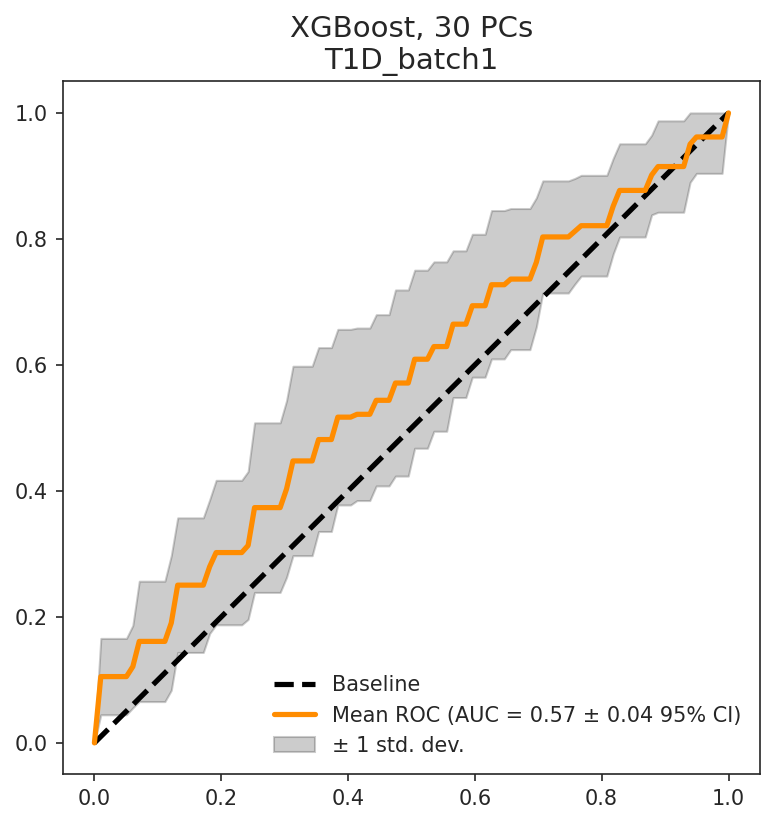

In [67]:
plot_nestedCV_ROC(xgb_auc_scores['tprs'], xgb_auc_scores['aucs'], title='XGBoost, 30 PCs\nT1D_batch1')

/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)


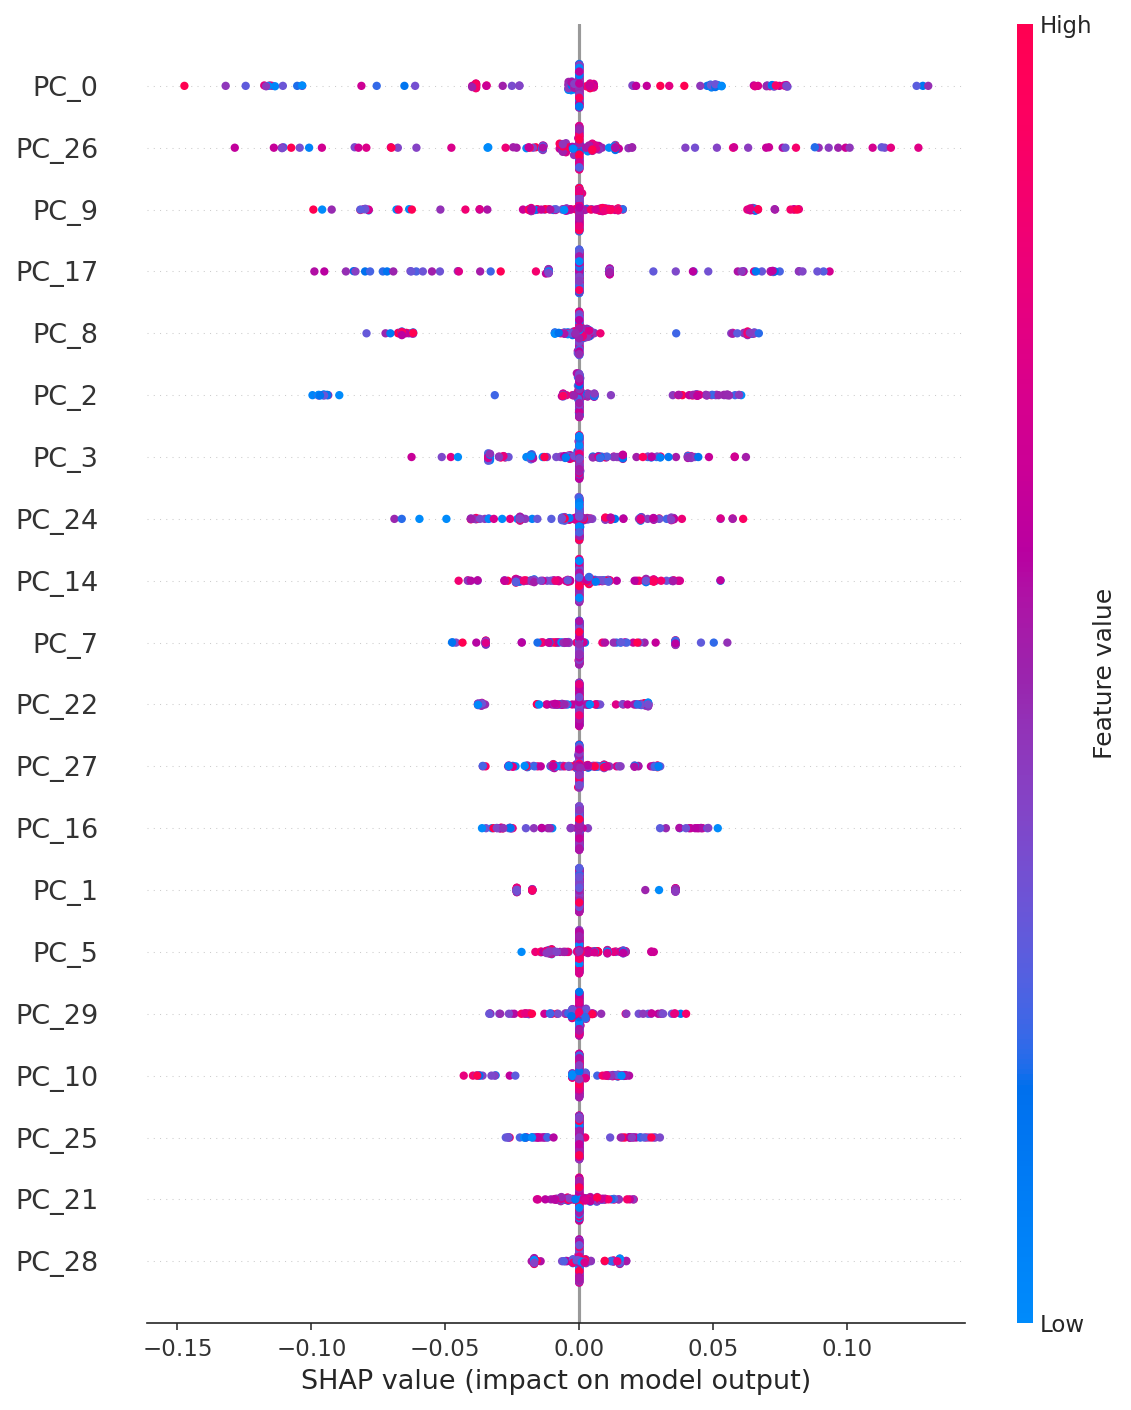

In [68]:
Xnob_t = data_prep.fit_transform(X_nob)
shap.summary_plot(np.array(xgb_average_shap), Xnob_t, show = False)

In [52]:
prep = [ ([i for i in X.columns if 'dim' in i], [StandardScaler(), umap.UMAP(n_components=25)], {'alias': 'PC'}),
         ('entropy', None) ]
data_prep = DataFrameMapper(prep, input_df=True, df_out=True)
xgb_umap_average_shap, xgb_umap_auc_scores = nested_cv_model(X_nob, y_nob, data_prep, model_name='xgboost', cv_repeats=3)


------------ CV Repeat number: 1

------ Fold Number: 1
F1 Score: 0.747
Balanced Accuracy: 0.467
AUC ROC: 0.435
26

------ Fold Number: 2
F1 Score: 0.789
Balanced Accuracy: 0.560
AUC ROC: 0.728
26

------ Fold Number: 3
F1 Score: 0.784
Balanced Accuracy: 0.515
AUC ROC: 0.528
26

------ Fold Number: 4
F1 Score: 0.776
Balanced Accuracy: 0.590
AUC ROC: 0.631
26

------ Fold Number: 5
F1 Score: 0.727
Balanced Accuracy: 0.531
AUC ROC: 0.674
26

------------ CV Repeat number: 2

------ Fold Number: 1
F1 Score: 0.757
Balanced Accuracy: 0.496
AUC ROC: 0.464
26

------ Fold Number: 2
F1 Score: 0.789
Balanced Accuracy: 0.560
AUC ROC: 0.464
26

------ Fold Number: 3
F1 Score: 0.645
Balanced Accuracy: 0.458
AUC ROC: 0.425
26

------ Fold Number: 4
F1 Score: 0.783
Balanced Accuracy: 0.575
AUC ROC: 0.586
26

------ Fold Number: 5
F1 Score: 0.740
Balanced Accuracy: 0.466
AUC ROC: 0.550
26

------------ CV Repeat number: 3

------ Fold Number: 1
F1 Score: 0.635
Balanced Accuracy: 0.451
AUC ROC: 0.480

<Axes: title={'center': 'XGBoost, 25 UMAPs\nT1D_batch1'}>

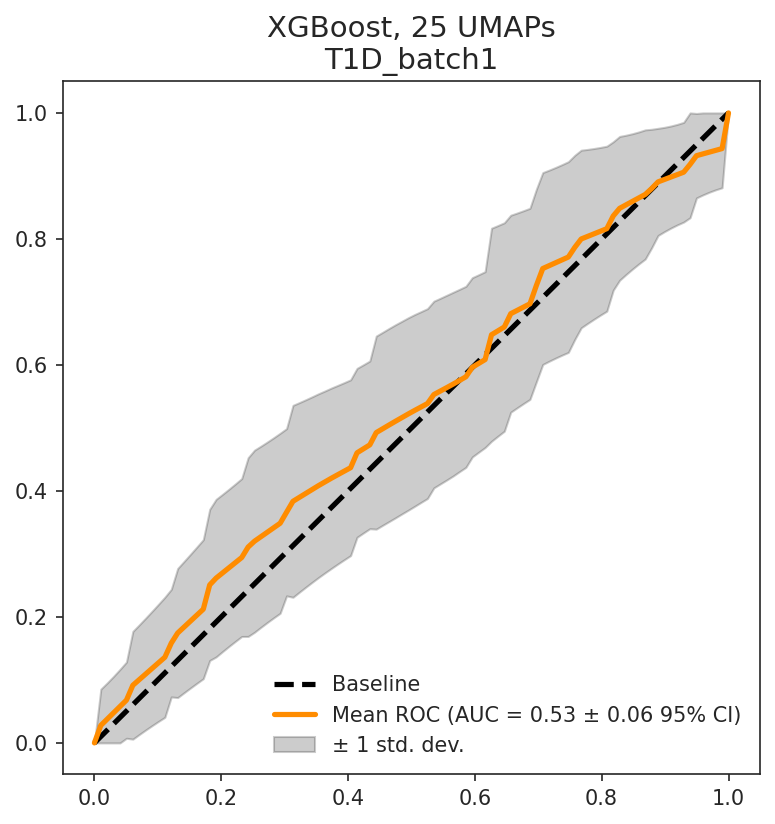

In [54]:
plot_nestedCV_ROC(xgb_umap_auc_scores['tprs'], xgb_umap_auc_scores['aucs'], title='XGBoost, 25 UMAPs\nT1D_batch1')

# **Different Data Splitting Strategy**

Implement batch aware data split into training and testing data sets.

In [34]:
X_train = df.loc[df.batch_name.isin(['T1D_batch2', 'rosati']), :].drop(columns=['patient_id', 'batch_name', 't1d_status', 'num_sequences']).reset_index(drop=True)
X_test = df.query("not (batch_name == 'T1D_batch1' & t1d_status == 'No')").loc[df.batch_name.isin(['T1D_batch1', 'aging']), :].drop(columns=['patient_id', 'batch_name', 't1d_status', 'num_sequences']).reset_index(drop=True)

y_train = df.loc[df.batch_name.isin(['T1D_batch2', 'rosati']), 't1d_status'].reset_index(drop=True).replace({'Yes': True, 'No': False}).map(int).values
y_test = df.query("not (batch_name == 'T1D_batch1' & t1d_status == 'No')").loc[df.batch_name.isin(['T1D_batch1', 'aging']), 't1d_status'].reset_index(drop=True).replace({'Yes': True, 'No': False}).map(int).values
X_train.head()

/scratch/ipykernel_4154441/2566218909.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = df.loc[df.batch_name.isin(['T1D_batch2', 'rosati']), 't1d_status'].reset_index(drop=True).replace({'Yes': True, 'No': False}).map(int).values
/scratch/ipykernel_4154441/2566218909.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = df.query("not (batch_name == 'T1D_batch1' & t1d_status == 'No')").loc[df.batch_name.isin(['T1D_batch1', 'aging']), 't1d_status'].reset_index(drop=True).replace({'Yes': True, 'No': False}).map(int

,entropy,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,...,dim_1270,dim_1271,dim_1272,dim_1273,dim_1274,dim_1275,dim_1276,dim_1277,dim_1278,dim_1279
0,14.319417,0.035409,0.098954,0.142133,0.150982,-0.066713,-0.017706,-0.093961,0.209040,0.142685,...,-0.002462,-0.026572,-0.105460,0.124097,-0.025214,0.156601,-0.046350,0.006814,-0.110837,0.041030
1,13.805074,0.037502,0.098644,0.140688,0.151790,-0.066058,-0.019611,-0.091857,0.211184,0.145149,...,-0.002659,-0.025249,-0.103518,0.121801,-0.025543,0.155784,-0.047368,0.005313,-0.112374,0.040593
2,13.918752,0.035802,0.098270,0.140881,0.150906,-0.064041,-0.020724,-0.092428,0.206969,0.144413,...,-0.000262,-0.026122,-0.105411,0.122716,-0.025580,0.155111,-0.047736,0.005706,-0.111430,0.041841
3,14.320187,0.034989,0.098506,0.141366,0.151412,-0.066603,-0.019907,-0.092862,0.208488,0.141353,...,-0.001958,-0.026529,-0.106346,0.123061,-0.025299,0.156202,-0.048037,0.003026,-0.110233,0.041809
4,14.695574,0.035668,0.099134,0.142483,0.151018,-0.068205,-0.018371,-0.094342,0.209524,0.142062,...,-0.004784,-0.026669,-0.105125,0.124389,-0.024597,0.155928,-0.046807,0.007403,-0.110679,0.041109


## RBFSampler Logistic regression with repeated 5-fold CV

Precision: 0.778
Recall: 0.966
F1-score: 0.862
Balanced Accuracy: 0.624
AUC-ROC: 0.542


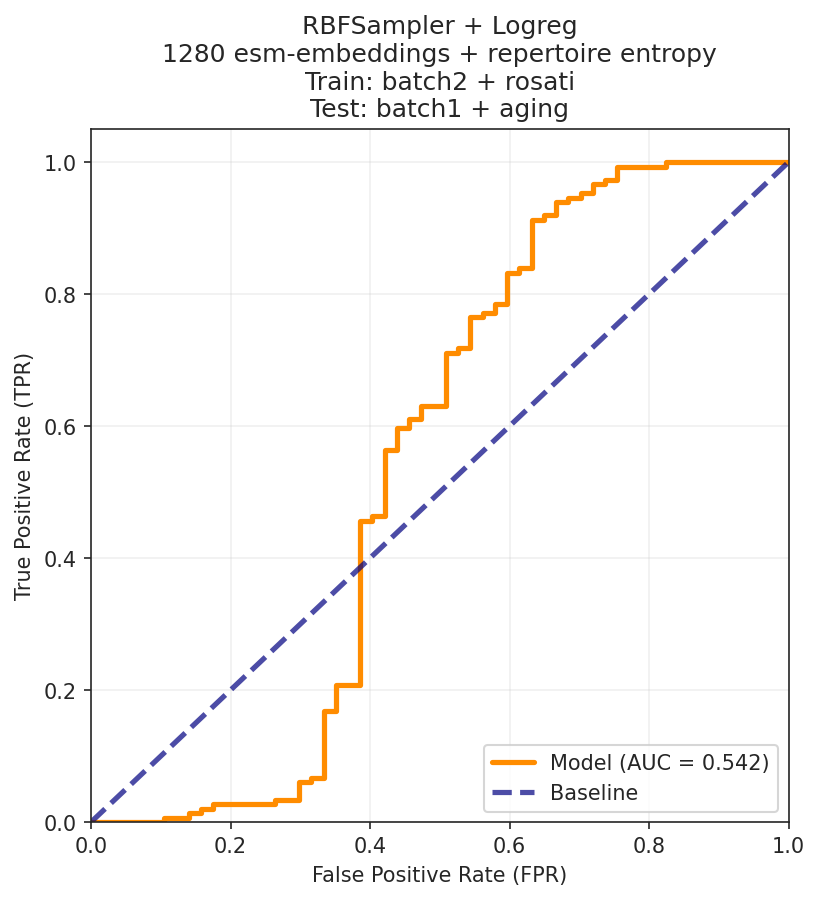

In [ ]:
with suppress_warnings([FutureWarning, ExperimentalWarning, ConvergenceWarning]):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    best_params = optimize_kernel_logit_params(X_train, y_train, cv=cv)

    best_logreg = Pipeline([
        ('rbf', RBFSampler(random_state=42)),
        ('logreg', LogisticRegression(penalty='l2', random_state=42))
    ]).set_params(**best_params)
    best_logreg.fit(X_train, y_train)

    y_pred = best_logreg.predict(X_test)
    y_proba = best_logreg.predict_proba(X_test)[:, 1]

    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
    plot_CV_ROC(y_test, y_proba, model_name='RBFSampler+LogReg', color='darkorange', title="RBFSampler + LoReg\n1280 esm-embeddings + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

<Axes: title={'center': 'RBFSampler + Logreg\n1280 esm-embeddings + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging'}, xlabel='Recall (Sensitivity)', ylabel='Precision'>

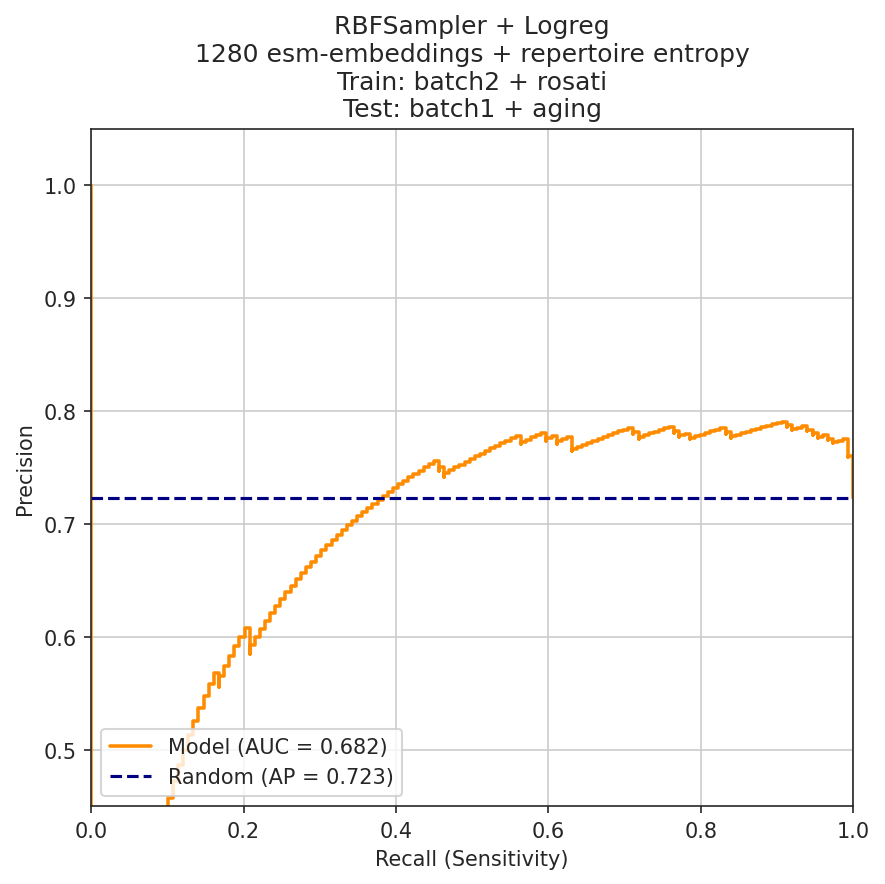

In [ ]:
plot_CV_PR(y_test, best_logreg.predict_proba(X_test)[:, 1], model_name='RBFSampler+LogReg', color='darkorange', title="RBFSampler + Logreg\n1280 esm-embeddings + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

## Random Forest with repeated 5-fold CV

Perform classification on tuned Random Forest classifier with hyperparameter tuning for PCA

Precision: 0.750
Recall: 0.966
F1-score: 0.845
Balanced Accuracy: 0.562
AUC-ROC: 0.836


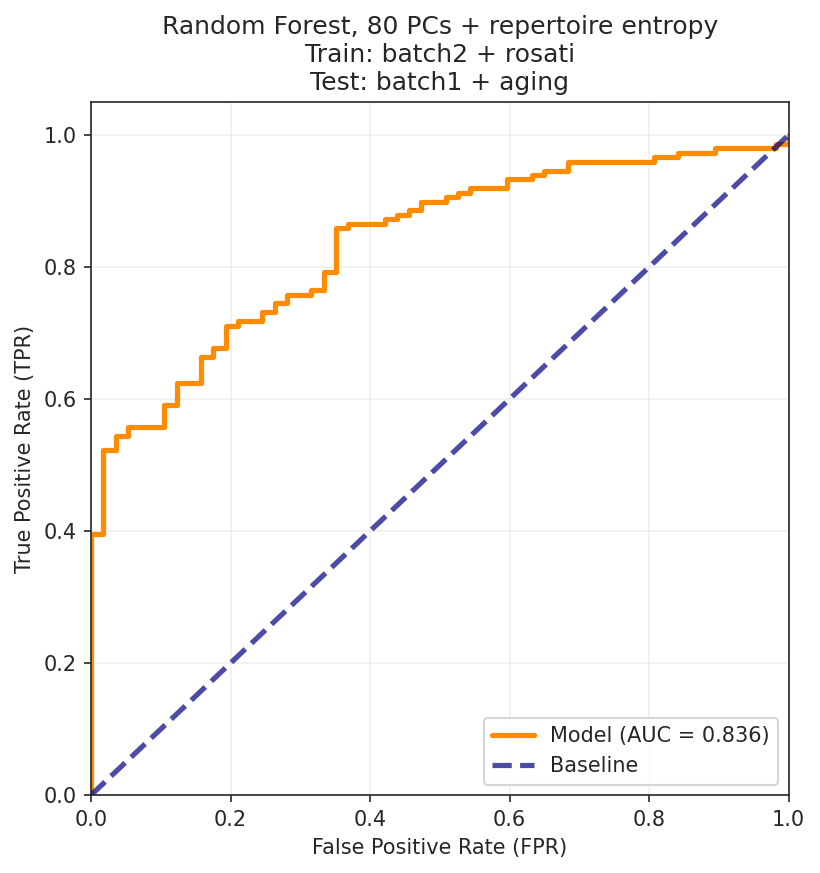

In [ ]:
with suppress_warnings([FutureWarning, ExperimentalWarning]):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    dim_reduct_method = 'pca'
    best_params = optimize_random_forest_params2(X_train, y_train, dim_reduct_method=dim_reduct_method, cv=cv)

    # Prepare  dictionary with best hyperparams for random forest classifier
    rf_best_params = {
            'max_depth': best_params['max_depth'],
            'min_samples_split': best_params['min_samples_split'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'criterion': best_params['criterion'],
            'max_features': best_params['max_features'],
            'class_weight': {0: best_params['weight_neg'], 1: best_params['weight_pos']},
            'n_estimators': 200,
            'n_jobs': -1,
            'random_state': 42
        }

    # Create the preprocessing pipeline with best hyperparams for columns that need processing
    processing_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_reduct', PCA(best_params['n_components'], svd_solver='arpack', random_state=42) if dim_reduct_method in ['pca', 'PCA'] else umap.UMAP(
            n_components=best_params['n_components'],
            n_neighbors=best_params['n_neighbors'],
            min_dist=best_params['min_dist'],
            metric=best_params['metric'],
            random_state=42))
    ])

    # ColumnTransformer handles both processed and skipped features
    best_preprocesser = ColumnTransformer([
        ('process', processing_pipeline, [i for i in X.columns if 'dim' in i]),
        ('passthrough', 'passthrough', ['entropy'])
    ])

    best_model = RandomForestClassifier(**rf_best_params)
    best_rf_pca = make_pipeline(best_preprocesser, best_model)
    best_rf_pca.fit(X_train, y_train)

    y_pred = best_rf_pca.predict(X_test)
    y_proba = best_rf_pca.predict_proba(X_test)[:, 1]

    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
    plot_CV_ROC(y_test, y_proba, model_name='RBFSampler+LogReg', color='darkorange', title=f"Random Forest, {best_params['n_components']} PCs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

<Axes: title={'center': 'Random Forest, 80 PCs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging'}, xlabel='Recall (Sensitivity)', ylabel='Precision'>

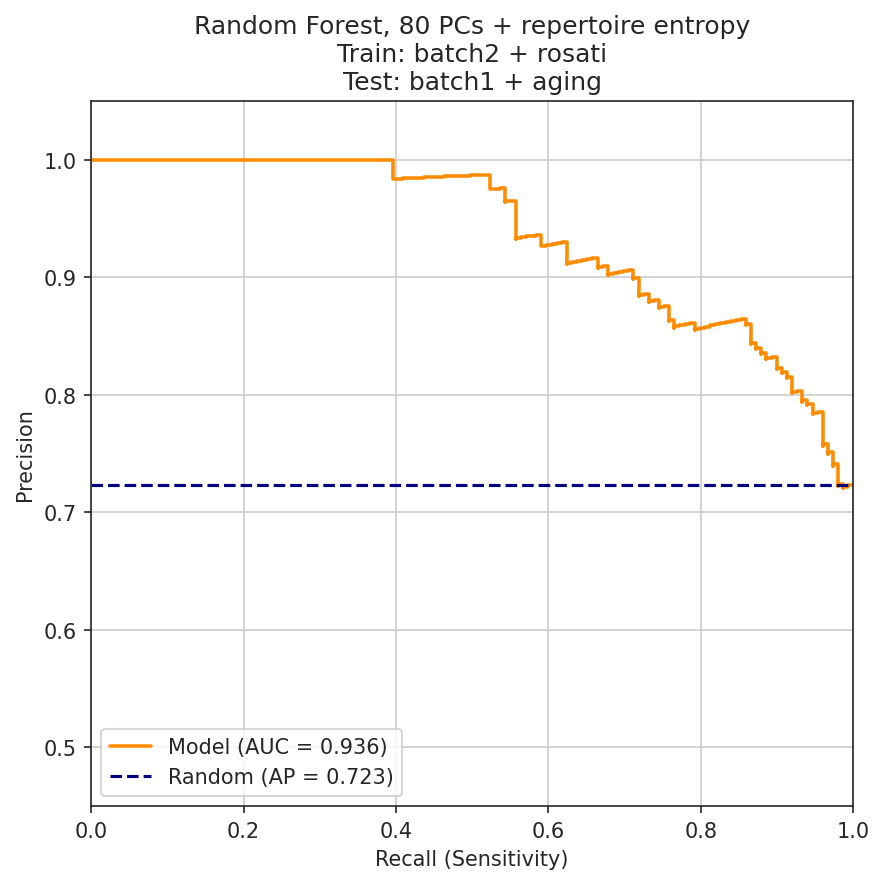

In [ ]:
plot_CV_PR(y_test, best_rf_pca.predict_proba(X_test)[:, 1], model_name='RBFSampler+LogReg', color='darkorange', title="Random Forest, 80 PCs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

Perform classification on tuned Random Forest classifier with hyperparameter tuning for UMAP

/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Precision: 0.730
Recall: 0.980
F1-score: 0.837
Balanced Accuracy: 0.516
AUC-ROC: 0.809


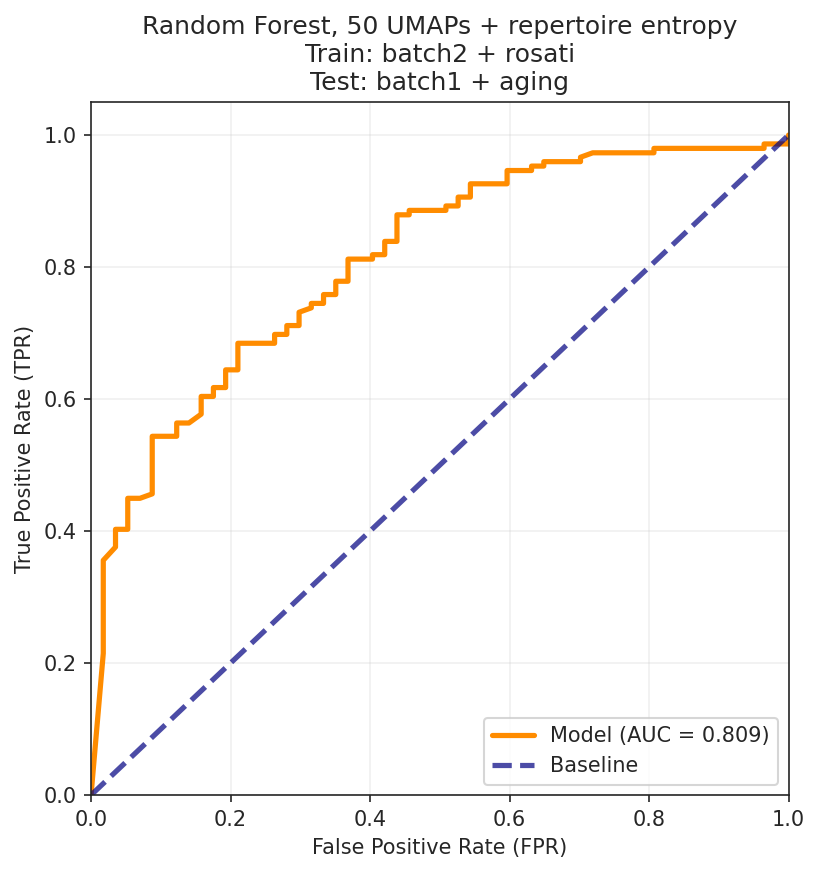

In [ ]:
with suppress_warnings([FutureWarning, ExperimentalWarning]):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    dim_reduct_method = 'umap'
    best_params = optimize_random_forest_params2(X_train, y_train, dim_reduct_method=dim_reduct_method, cv=cv)

    # Prepare  dictionary with bets hyperparams for xgboost classifier
    rf_best_params = {
            'max_depth': best_params['max_depth'],
            'min_samples_split': best_params['min_samples_split'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'criterion': best_params['criterion'],
            'max_features': best_params['max_features'],
            'class_weight': {0: best_params['weight_neg'], 1: best_params['weight_pos']},
            'n_estimators': 200,
            'n_jobs': -1,
            'random_state': 42
        }

    # Create the preprocessing pipeline with best hyperparams for columns that need processing
    processing_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_reduct', PCA(best_params['n_components'], svd_solver='arpack', random_state=42) if dim_reduct_method in ['pca', 'PCA'] else umap.UMAP(
            n_components=best_params['umap_n_components'],
            n_neighbors=best_params['umap_n_neighbors'],
            min_dist=best_params['umap_min_dist'],
            metric=best_params['umap_metric'],
            random_state=42))
    ])

    # ColumnTransformer handles both processed and skipped features
    best_preprocesser = ColumnTransformer([
        ('process', processing_pipeline, [i for i in X.columns if 'dim' in i]),
        ('passthrough', 'passthrough', ['entropy'])
    ])

    best_model = RandomForestClassifier(**rf_best_params)
    best_rf_umap = make_pipeline(best_preprocesser, best_model)
    best_rf_umap.fit(X_train, y_train)

    y_pred = best_rf_umap.predict(X_test)
    y_proba = best_rf_umap.predict_proba(X_test)[:, 1]

    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
    plot_CV_ROC(y_test, y_proba, model_name='RBFSampler+LogReg', color='darkorange', title=f"Random Forest, {best_params['umap_n_components']} UMAPs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: title={'center': 'Random Forest, 50 UMAPs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging'}, xlabel='Recall (Sensitivity)', ylabel='Precision'>

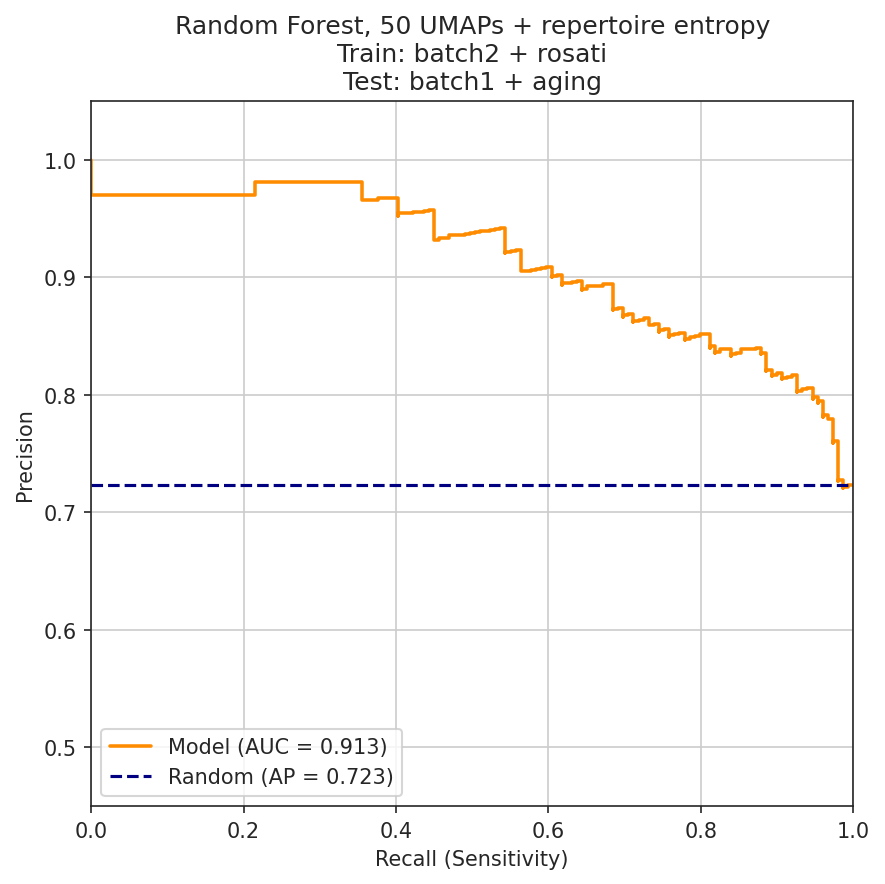

In [ ]:
plot_CV_PR(y_test, best_rf_umap.predict_proba(X_test)[:, 1], model_name='RBFSampler+LogReg', color='darkorange', title="Random Forest, 50 UMAPs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

## XGBoost with repeated 5-fold CV

Perform classification on XGBoost classifier with hyperparameter tuning for PCA

Precision: 0.762
Recall: 0.966
F1-score: 0.852
Balanced Accuracy: 0.588
AUC-ROC: 0.782


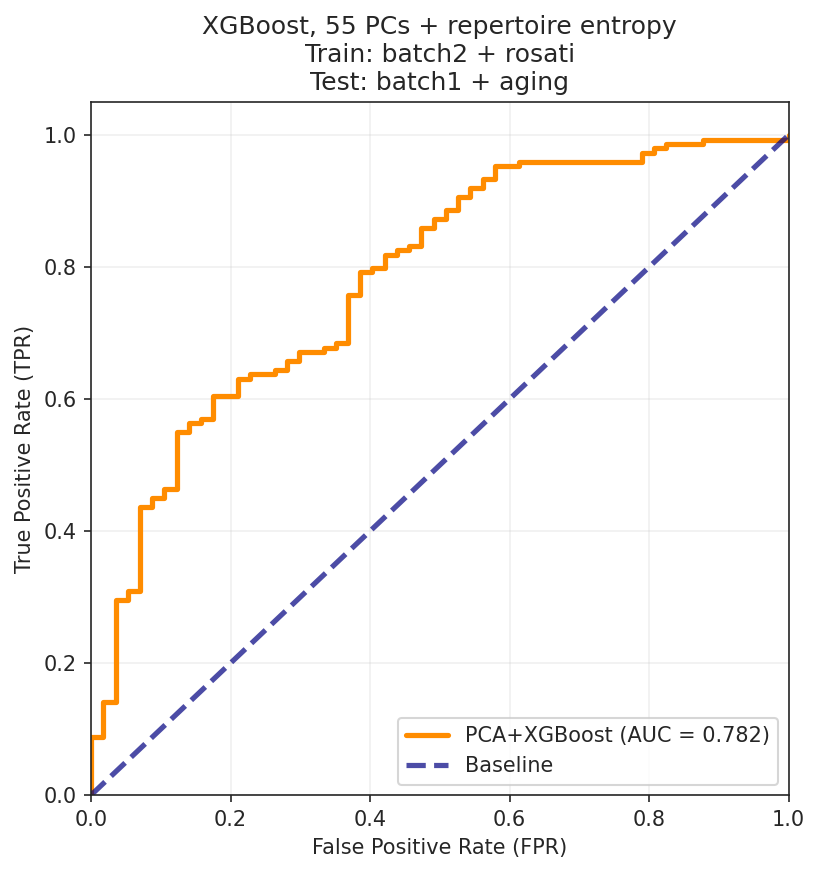

In [120]:
with suppress_warnings([FutureWarning, ExperimentalWarning]):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    dim_reduct = 'pca'
    best_params = optimize_xgboost_params2(X_train, y_train, dim_reduct_method=dim_reduct, cv=cv)

    # Prepare  dictionary with bets hyperparams for xgboost classifier
    xgb_best_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": 'hist',
        "device": "cuda",
        "random_state": 42,
        "scale_pos_weight": best_params["scale_pos_weight"],
        "learning_rate": best_params["learning_rate"],
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "subsample": best_params["subsample"],
        "colsample_bytree": best_params["colsample_bytree"],
        "lambda": best_params["lambda"],
        "gamma": best_params["gamma"]
        }

    # Create the preprocessing pipeline with best hyperparams for columns that need processing
    processing_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_reduct', PCA(best_params['n_components'], svd_solver='arpack', random_state=42) if dim_reduct in ['pca', 'PCA'] else umap.UMAP(
            n_components=best_params['umap_n_components'],
            n_neighbors=best_params['umap_n_neighbors'],
            min_dist=best_params['umap_min_dist'],
            metric=best_params['umap_metric'],
            random_state=42))
    ])

    # ColumnTransformer handles both processed and skipped features
    best_preprocesser = ColumnTransformer([
        ('process', processing_pipeline, [i for i in X.columns if 'dim' in i]),
        ('passthrough', 'passthrough', ['entropy'])
    ])

    dtrain = xgb.DMatrix(best_preprocesser.fit_transform(X_train), label=y_train)
    dtest = xgb.DMatrix(best_preprocesser.transform(X_test), label=y_test)

    best_xgb_pca = xgb.train(
        xgb_best_params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtest, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_proba_xgb_pca = best_xgb_pca.predict(dtest)
    y_pred = (y_proba > 0.5).astype(int)

    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
    plot_CV_ROC(y_test, y_proba_xgb_pca, model_name='PCA+XGBoost', color='darkorange', title=f"XGBoost, {best_params['n_components']} PCs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

<Axes: title={'center': 'XGBoost, 55 PСs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging'}, xlabel='Recall (Sensitivity)', ylabel='Precision'>

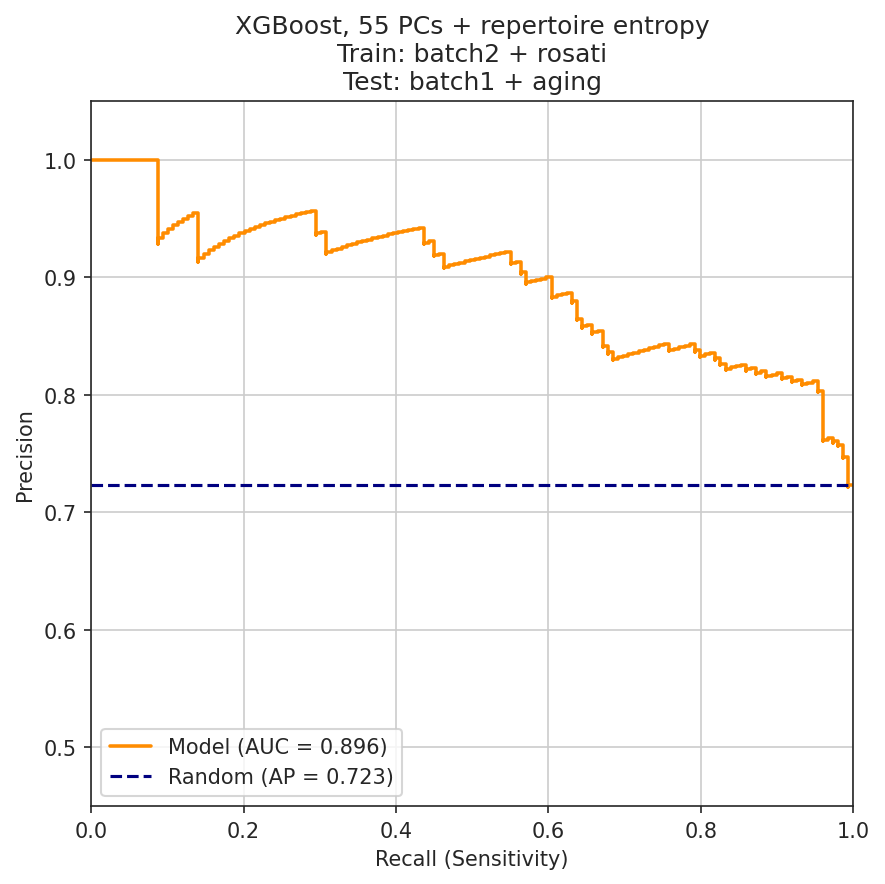

In [ ]:
plot_CV_PR(y_test, y_proba_xgb_pca, model_name='RBFSampler+LogReg', color='darkorange', title="XGBoost, 55 PСs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

Perform classification on XGBoost classifier with hyperparameter tuning for UMAP

Precision: 0.762
Recall: 0.966
F1-score: 0.852
Balanced Accuracy: 0.588
AUC-ROC: 0.841


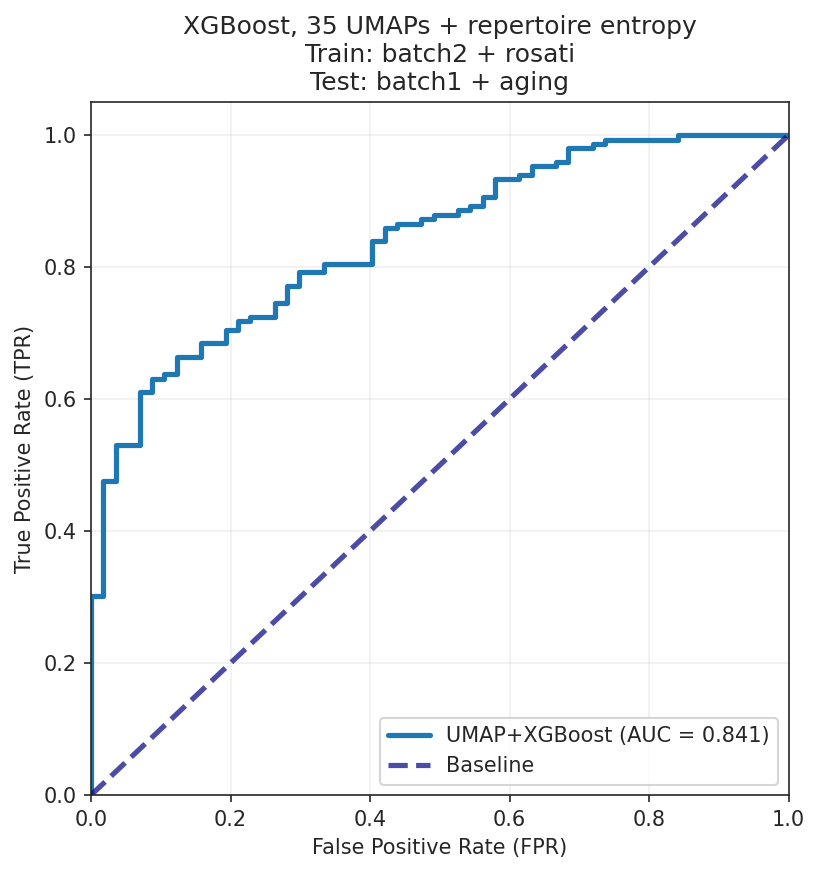

In [ ]:
with suppress_warnings([FutureWarning, ExperimentalWarning]):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    dim_reduct = 'umap'
    best_params = optimize_xgboost_params2(X_train, y_train, dim_reduct_method=dim_reduct, cv=cv)

    # Prepare  dictionary with bets hyperparams for xgboost classifier
    xgb_best_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": 'hist',
        "device": "cuda",
        "random_state": 42,
        "scale_pos_weight": best_params["scale_pos_weight"],
        "learning_rate": best_params["learning_rate"],
        "max_depth": best_params["max_depth"],
        "min_child_weight": best_params["min_child_weight"],
        "subsample": best_params["subsample"],
        "colsample_bytree": best_params["colsample_bytree"],
        "lambda": best_params["lambda"],
        "gamma": best_params["gamma"]
        }

    # Create the preprocessing pipeline with best hyperparams for columns that need processing
    processing_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dim_reduct', PCA(best_params['n_components'], svd_solver='arpack', random_state=42) if dim_reduct in ['pca', 'PCA'] else umap.UMAP(
            n_components=best_params['umap_n_components'],
            n_neighbors=best_params['umap_n_neighbors'],
            min_dist=best_params['umap_min_dist'],
            metric=best_params['umap_metric']))
    ])

    # ColumnTransformer handles both processed and skipped features
    best_preprocesser = ColumnTransformer([
        ('process', processing_pipeline, [i for i in X.columns if 'dim' in i]),
        ('passthrough', 'passthrough', ['entropy'])
    ])

    dtrain = xgb.DMatrix(best_preprocesser.fit_transform(X_train), label=y_train)
    dtest = xgb.DMatrix(best_preprocesser.transform(X_test), label=y_test)

    best_xgb_umap = xgb.train(
        xgb_best_params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtest, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_proba_xgb_umap = best_xgb_umap.predict(dtest)
    y_pred = (y_proba > 0.5).astype(int)

    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_xgb_umap):.3f}")
    plot_CV_ROC(y_test, y_proba_xgb_umap, model_name='UMAP+XGBoost', color='darkorange', title=f"XGBoost, {best_params['umap_n_components']} UMAPs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

<Axes: title={'center': 'XGBoost, 35 UMAPs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging'}, xlabel='Recall (Sensitivity)', ylabel='Precision'>

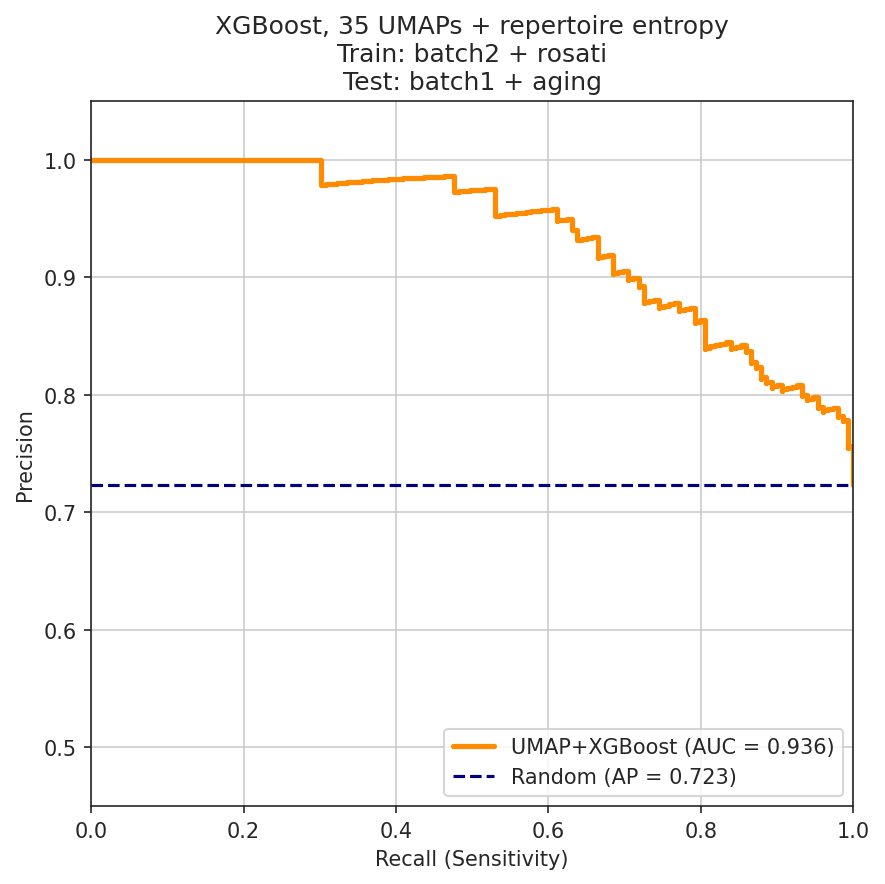

In [118]:
plot_CV_PR(y_test, y_proba_xgb_umap, model_name='UMAP+XGBoost',color='darkorange', title=f"XGBoost, 35 UMAPs + repertoire entropy\nTrain: batch2 + rosati\nTest: batch1 + aging")

## Overall figures

/home/adakhnovets/miniforge3/envs/ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


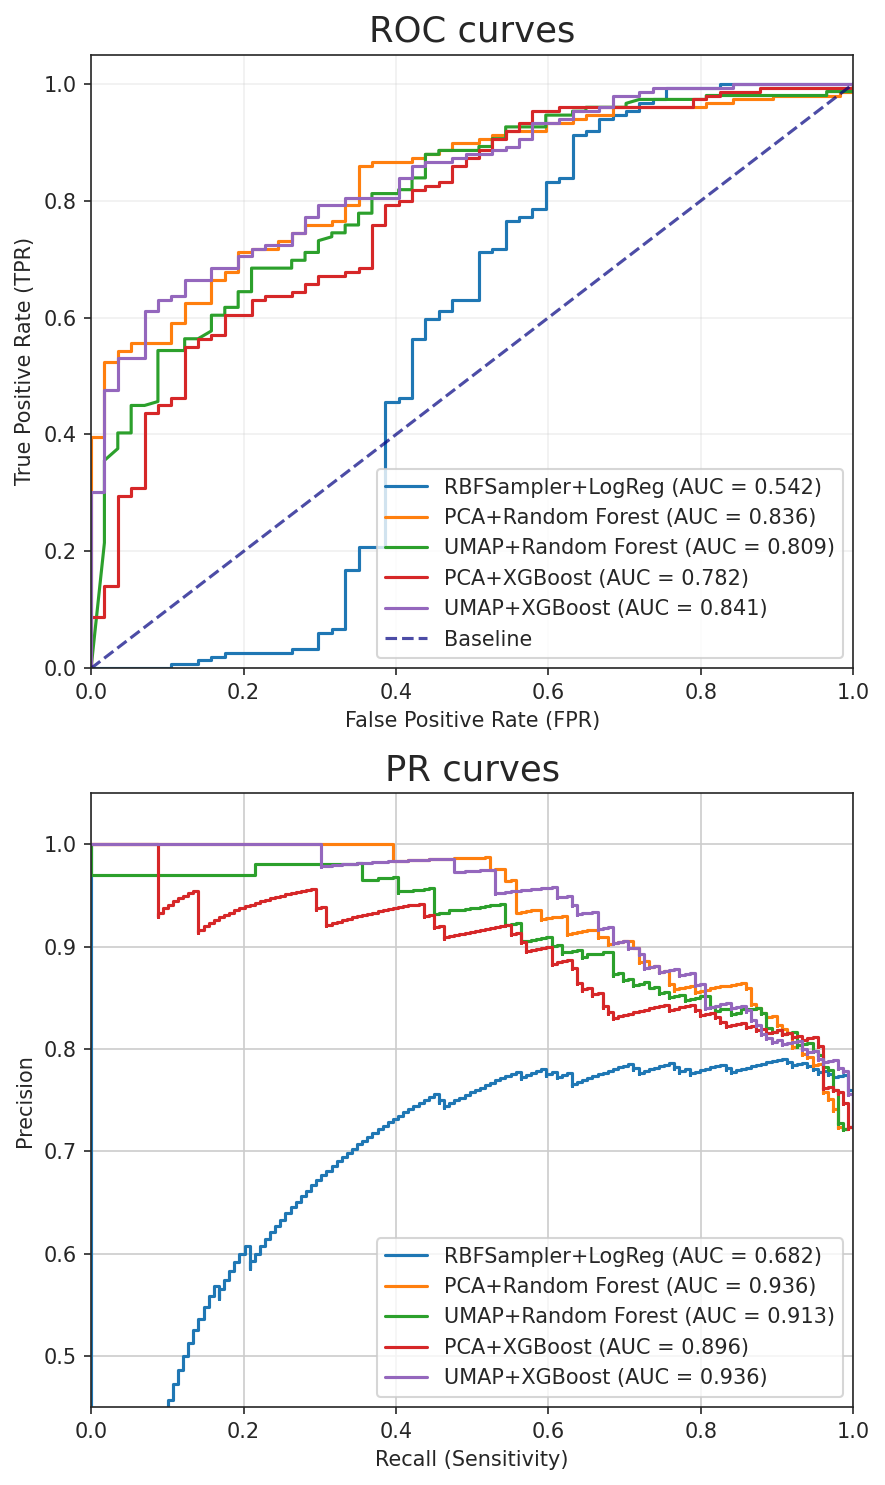

In [127]:
# Set up figure
fig, axs = plt.subplots(2, 1, figsize=(6, 10), dpi=150)
titles = ['ROC curves', 'PR curves']
plot_funcs = [plot_CV_ROC, plot_CV_PR]

# Models' predicted probabilities
models = [
    ('RBFSampler+LogReg', best_logreg.predict_proba(X_test)[:, 1]),
    ('PCA+Random Forest', best_rf_pca.predict_proba(X_test)[:, 1]),
    ('UMAP+Random Forest', best_rf_umap.predict_proba(X_test)[:, 1]),
    ('PCA+XGBoost', y_proba_xgb_pca),
    ('UMAP+XGBoost', y_proba_xgb_umap)
]

# Plot curves
for ax, title, plot_func in zip(axs, titles, plot_funcs):
    for name, preds in models:
        plot_func(
            y_test, preds,
            model_name=name,
            title=None,
            color=None,
            plot_baseline=(plot_func == plot_CV_ROC and name == 'UMAP+XGBoost'),
            lw=1.5,
            ax=ax
        )
    ax.set_title(title, fontsize=17)

plt.tight_layout()

In [36]:
print(f"RBFSampler+LogReg agg score: {np.mean(np.array([0.624, 0.862, 0.542])):.3f}")
print(f"PCA+Random forest agg score: {np.mean(np.array([0.562, 0.845, 0.836])):.3f}")
print(f"UMAP+Random forest agg score: {np.mean(np.array([0.516, 0.837, 0.809])):.3f}")
print(f"PCA+XGBoost agg score: {np.mean(np.array([0.588, 0.852, 0.782])):.3f}")
print(f"UMAP+XGBoost agg score: {np.mean(np.array([0.588, 0.852, 0.841])):.3f}")

RBFSampler+LogReg agg score: 0.676
PCA+Random forest agg score: 0.748
UMAP+Random forest agg score: 0.721
PCA+XGBoost agg score: 0.741
UMAP+XGBoost agg score: 0.760
